# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### Code for Data Vectorizers ###

In [ ]:
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from bs4 import BeautifulSoup
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import time

class assign7SVM_dtcrea:

	def __init__(self):
		print('nothing in the constructo\n')
		self.X_train = pd.DataFrame()  #for gridsearchcv
		self.X_test = pd.DataFrame()   #for gridsearchcv	
		self.y_train = pd.Series([])   #y_train for gridsearchcv

		self.xtrain = pd.DataFrame()
		self.xtest = pd.DataFrame()
		self.xval = pd.DataFrame()
		
		self.ytrain = pd.Series([])
		self.ytest = pd.Series([])
		self.yval = pd.Series([])

	#gridsearchcv parameters -- start
	@property
	def X_train(self):
	    return self._X_train

	@X_train.setter
	def X_train(self,new_X_train):
	    self._X_train = new_X_train        

	@property
	def X_test(self):
	    return self._X_test

	@X_test.setter
	def X_test(self,new_X_test):
	    self._X_test = new_X_test

	@property
	def y_train(self):
	    return self._y_train

	@y_train.setter
	def y_train(self,new_y_train):
	    self._y_train = new_y_train
		
	@property
	def y_test(self):
	    return self._y_test

	@y_test.setter
	def y_test(self,new_y_test):
	    self._y_test = new_y_test
	#gridsearchcv parameters -- end    
	    	
	@property
	def xtrain(self):
	    return self._xtrain

	@xtrain.setter
	def xtrain(self,new_xtrain):
	    self._xtrain = new_xtrain        	
 

	@property
	def ytrain(self):
	    return self._ytrain

	@ytrain.setter
	def ytrain(self,new_ytrain):
	    self._ytrain = new_ytrain

	@property
	def xval(self):
	    return self._xval

	@xval.setter
	def xval(self,new_xval):
	    self._xval = new_xval 
		
	@property
	def yval(self):
	    return self._yval

	@yval.setter
	def yval(self,new_yval):
	    self._yval = new_yval
        
	# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
	def partition(self,x):
		if x < 3:
			return 0
		return 1

	def write_ft_data(self,fnme,opdata):

		#fname = 'E:/appliedaicourse/assignments/dblite/kdtree_50k/' + fnme
		fname = 'E:/appliedaicourse/assignments/dblite/1kpts' + fnme
		with open(fname, 'wb') as fp:
			pickle.dump(opdata, fp)

	def write_data(self,fnme,opdata):    

		#fname = 'E:/appliedaicourse/assignments/dblite/kdtree_50k/' + fnme
		
		fname = 'E:/appliedaicourse/assignments/dblite/1kpts' + fnme
		print(fname)
		with open(fname, 'wb') as fp:
			pickle.dump(opdata, fp)
		

	def decontracted(self,phrase):
		# specific
		phrase = re.sub(r"won't", "will not", phrase)
		phrase = re.sub(r"can\'t", "can not", phrase)

		# general
		phrase = re.sub(r"n\'t", " not", phrase)
		phrase = re.sub(r"\'re", " are", phrase)
		phrase = re.sub(r"\'s", " is", phrase)
		phrase = re.sub(r"\'d", " would", phrase)
		phrase = re.sub(r"\'ll", " will", phrase)
		phrase = re.sub(r"\'t", " not", phrase)
		phrase = re.sub(r"\'ve", " have", phrase)
		phrase = re.sub(r"\'m", " am", phrase)

		return phrase			



	# Combining all the above statements 
	def rw_preproc(self,xdata):
		stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
		"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
		'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
		'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
		'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
		'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
		'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
		'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
		'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
		'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
		's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
		've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
		"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
		"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
		'won', "won't", 'wouldn', "wouldn't"])

		preprocessed_reviews = []

		# tqdm is for printing the status bar
		
		for sentance in tqdm(xdata.values):
			sentance = re.sub(r"http\S+", "", sentance)
			sentance = BeautifulSoup(sentance, 'lxml').get_text()
			sentance = self.decontracted(sentance)
			sentance = re.sub("\S*\d\S*", "", sentance).strip()
			sentance = re.sub('[^A-Za-z]+', ' ', sentance)
			# https://gist.github.com/sebleier/554280
			sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
			preprocessed_reviews.append(sentance.strip())
		return preprocessed_reviews


	def getreviews(self, nrows):
		X_trn = pd.DataFrame()		
		# using SQLite Table to read data.
		filepath = os.path.abspath('E:/appliedaicourse/assignments/dblite/database.db') 
		assert os.path.exists(filepath), 'the file does not exist'
		con = sqlite3.connect(filepath) 
		#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)
		filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT """ + str(nrows), con)

		#changing reviews with score less than 3 to be positive and vice-versa
		actualScore = filtered_data['Score']
		positiveNegative = actualScore.map(self.partition) 
		filtered_data['Score'] = positiveNegative
		#Sorting data according to ProductId in ascending order
		sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')	
		#Deduplication of entries
		final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
		final.shape

		final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

		#Before starting the next phase of preprocessing lets see the number of entries left
		print(final.shape)

		#How many positive and negative reviews are present in our dataset?
		final['Score'].value_counts()

		X_trn, X_tst, self.y_train, self.y_test = train_test_split(final['Text'], final['Score'], stratify= final['Score'],test_size=0.2, random_state=42)
		xtrn, xval, self.ytrain, self.yval   = train_test_split(X_trn, self.y_train, test_size=0.2, random_state=42)

		self.X_train = self.rw_preproc(X_trn)
		self.X_test  = self.rw_preproc(X_tst)
		self.xtrain   = self.rw_preproc(xtrn)
		self.xval   = self.rw_preproc(xval)


	def BOWVect_WSmote(self):
		xvtrain = []
		xvval = []
		X_v_train = []
		X_v_test = []
		bowsvmXtrain_scaled = []
		bowsvmXtest_scaled = []
		bowsvmxtrain_scaled = []
		bowsvmxval_scaled = []

		#this is for the roc auc score	
		count_vect = CountVectorizer(max_features=500) #in scikit-learn
		xvtrain = count_vect.fit_transform(self.xtrain)		
		xvval = count_vect.transform(self.xval)

		x_res_xvtrn, y_res_trn = SMOTE().fit_sample(xvtrain, self.ytrain) 
		x_res_xvval, y_res_val = SMOTE().fit_sample(xvval, self.yval)

		print("Shape after resampling x:", x_res_xvtrn.shape)
		print("Shape after resampling y:", x_res_xvval.shape)
		print("Shape after resampling x:", len(y_res_trn))
		print("Shape after resampling y:", len(y_res_val))

		#this is for gridsearchcv
		count_vect_1 = CountVectorizer(max_features=500) #in scikit-learn
		X_v_train = count_vect_1.fit_transform(self.X_train)
		X_v_test = count_vect_1.transform(self.X_test)

		x_res_Xvtrain, y_res_train = SMOTE().fit_sample(X_v_train, self.y_train) 
		x_res_Xvtest, y_res_test = SMOTE().fit_sample(X_v_test, self.y_test) 
		

		# checking the shape of x_resample and y_resample
		print("Shape after resampling x:", x_res_Xvtrain.shape)
		print("Shape after resampling y:", x_res_Xvtest.shape)
		print("Shape after resampling x:", len(y_res_train))
		print("Shape after resampling y:", len(y_res_test))
		print('\n\n')
		print('='*50)
		print("some feature names ", count_vect.get_feature_names()[:100])
		print('='*50)

		print("the type of count vectorizer ",type(xvtrain))
		print("the shape of out text BOW vectorizer ",xvtrain.get_shape())
		print("the number of unique words ", xvtrain.get_shape()[1])

		scaler_1 = StandardScaler(with_mean=False)              
		bowsvmXtrain_scaled = scaler_1.fit_transform(x_res_Xvtrain)     
		bowsvmXtest_scaled = scaler_1.transform(x_res_Xvtest)     
		

		scaler = StandardScaler(with_mean=False)              
		bowsvmxtrain_scaled = scaler.fit_transform(x_res_xvtrn)		
		bowsvmxval_scaled = scaler.transform(x_res_xvval)
				

		self.write_data('/balanced/bowvectorizer/ppvectscld_x_train',bowsvmXtrain_scaled)
		self.write_data('/balanced/bowvectorizer/ppvectscld_x_test',bowsvmXtest_scaled)
		self.write_data('/balanced/bowvectorizer/ppvectscld_xtrain',bowsvmxtrain_scaled)
		self.write_data('/balanced/bowvectorizer/ppvectscld_xval',bowsvmxval_scaled)
		self.write_data('/balanced/bowvectorizer/y_train',y_res_train)
		self.write_data('/balanced/bowvectorizer/y_test',y_res_test)
		self.write_data('/balanced/bowvectorizer/ytrain',y_res_trn)
		self.write_data('/balanced/bowvectorizer/yval',y_res_val)
		self.write_ft_data('/balanced/bowvectorizer/bow_feat',count_vect_1.get_feature_names())
		
	def BOWVectorizer(self):
		xvtrain = []
		xvval = []
		X_v_train = []
		X_v_test = []
		bowsvmXtrain_scaled = []
		bowsvmXtest_scaled = []
		bowsvmxtrain_scaled = []
		bowsvmxval_scaled = []

		#this is for the roc auc score	
		count_vect = CountVectorizer(max_features=1000) #in scikit-learn
		xvtrain = count_vect.fit_transform(self.xtrain)		
		xvval = count_vect.transform(self.xval)

		#this is for gridsearchcv
		count_vect_1 = CountVectorizer(max_features=1000) #in scikit-learn
		X_v_train = count_vect_1.fit_transform(self.X_train)
		X_v_test = count_vect_1.transform(self.X_test)

		print("some feature names ", count_vect.get_feature_names()[:100])
		print('='*50)

		print("the type of count vectorizer ",type(xvtrain))
		print("the shape of out text BOW vectorizer ",xvtrain.get_shape())
		print("the number of unique words ", xvtrain.get_shape()[1])

		scaler_1 = StandardScaler(with_mean=False)              
		bowsvmXtrain_scaled = scaler_1.fit_transform(X_v_train)     
		bowsvmXtest_scaled = scaler_1.transform(X_v_test)     
		

		scaler = StandardScaler(with_mean=False)              
		bowsvmxtrain_scaled = scaler.fit_transform(xvtrain)		
		bowsvmxval_scaled = scaler.transform(xvval)
				
		print("the shape of Xtrain BOW vectorizer ",bowsvmXtrain_scaled.get_shape())
		print("the shape of Xtest BOW vectorizer ",bowsvmXtest_scaled.get_shape())
		print("the shape of xtrain BOW vectorizer ",bowsvmxtrain_scaled.get_shape())
		print("the shape of xtest BOW vectorizer ",bowsvmxval_scaled.get_shape())

		self.write_data('/unbalanced/bowvectorizer/ppvectscld_x_train',bowsvmXtrain_scaled)
		self.write_data('/unbalanced/bowvectorizer/ppvectscld_x_test',bowsvmXtest_scaled)
		self.write_data('/unbalanced/bowvectorizer/ppvectscld_xtrain',bowsvmxtrain_scaled)
		self.write_data('/unbalanced/bowvectorizer/ppvectscld_xval',bowsvmxval_scaled)
		self.write_data('/unbalanced/bowvectorizer/y_train',self.y_train)
		self.write_data('/unbalanced/bowvectorizer/y_test',self.y_test)
		self.write_data('/unbalanced/bowvectorizer/ytrain',self.ytrain)
		self.write_data('/unbalanced/bowvectorizer/yval',self.yval)
		self.write_ft_data('/unbalanced/bowvectorizer/bow_feat',count_vect_1.get_feature_names())

	def TFIDFVect_WSmote(self):
		xvtrain = []
		xvval = []
		X_v_train = []
		X_v_test = []
		tidfsvmXtrain_scaled = []
		tidfsvmXtest_scaled = []
		tidfsvmxtrain_scaled = []
		tidfsvmxval_scaled = []

		#this is for the roc auc score	
		tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)  #in scikit-learn
		xvtrain = tf_idf_vect.fit_transform(self.xtrain)		
		xvval = tf_idf_vect.transform(self.xval)

		x_res_xvtrn, y_res_trn = SMOTE().fit_sample(xvtrain, self.ytrain) 
		x_res_xvval, y_res_val = SMOTE().fit_sample(xvval, self.yval)

		print("Shape after resampling x:", x_res_xvtrn.shape)
		print("Shape after resampling y:", x_res_xvval.shape)
		print("Shape after resampling x:", len(y_res_trn))
		print("Shape after resampling y:", len(y_res_val))

		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)
		X_v_test = tf_idf_vect_1.transform(self.X_test)
		
		x_res_Xvtrain, y_res_train = SMOTE().fit_sample(X_v_train, self.y_train) 
		x_res_Xvtest, y_res_test = SMOTE().fit_sample(X_v_test, self.y_test) 
		

		# checking the shape of x_resample and y_resample
		print("Shape after resampling x:", x_res_Xvtrain.shape)
		print("Shape after resampling y:", x_res_Xvtest.shape)
		print("Shape after resampling x:", len(y_res_train))
		print("Shape after resampling y:", len(y_res_test))

		scaler_1 = StandardScaler(with_mean=False)              
		tidfsvmXtrain_scaled = scaler_1.fit_transform(x_res_Xvtrain)     
		tidfsvmXtest_scaled = scaler_1.transform(x_res_Xvtest)     
		

		scaler = StandardScaler(with_mean=False)              
		tidfsvmxtrain_scaled = scaler.fit_transform(x_res_xvtrn)		
		tidfsvmxval_scaled = scaler.transform(x_res_xvval)
				

		self.write_data('/balanced/tfidfvectorizer/ppvectscld_x_train',tidfsvmXtrain_scaled)
		self.write_data('/balanced/tfidfvectorizer/ppvectscld_x_test',tidfsvmXtest_scaled)
		self.write_data('/balanced/tfidfvectorizer/ppvectscld_xtrain',tidfsvmxtrain_scaled)
		self.write_data('/balanced/tfidfvectorizer/ppvectscld_xval',tidfsvmxval_scaled)
		self.write_data('/balanced/tfidfvectorizer/y_train',y_res_train)
		self.write_data('/balanced/tfidfvectorizer/y_test',y_res_test)
		self.write_data('/balanced/tfidfvectorizer/ytrain',y_res_trn)
		self.write_data('/balanced/tfidfvectorizer/yval',y_res_val)
		
		self.write_ft_data('/balanced/tfidfvectorizer/tfidf_feat',tf_idf_vect_1.get_feature_names())
		print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
		print('='*50)

	def TFIDFVectorizer(self):
		xvtrain = []
		xvval = []
		X_v_train = []
		X_v_test = []
		tidfsvmXtrain_scaled = []
		tidfsvmXtest_scaled = []
		tidfsvmxtrain_scaled = []
		tidfsvmxval_scaled = []

		#this is for the roc auc score	
		tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)  #in scikit-learn
		xvtrain = tf_idf_vect.fit_transform(self.xtrain)		
		xvval = tf_idf_vect.transform(self.xval)

		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)
		X_v_test = tf_idf_vect_1.transform(self.X_test)
		

		scaler_1 = StandardScaler(with_mean=False)              
		tidfsvmXtrain_scaled = scaler_1.fit_transform(X_v_train.toarray())     
		tidfsvmXtest_scaled = scaler_1.transform(X_v_test)     
		

		scaler = StandardScaler(with_mean=False)              
		tidfsvmxtrain_scaled = scaler.fit_transform(xvtrain.toarray())		
		tidfsvmxval_scaled = scaler.transform(xvval)
				

		self.write_data('/unbalanced/tfidfvectorizer/ppvectscld_x_train',tidfsvmXtrain_scaled)
		self.write_data('/unbalanced/tfidfvectorizer/ppvectscld_x_test',tidfsvmXtest_scaled)
		self.write_data('/unbalanced/tfidfvectorizer/ppvectscld_xtrain',tidfsvmxtrain_scaled)
		self.write_data('/unbalanced/tfidfvectorizer/ppvectscld_xval',tidfsvmxval_scaled)
		self.write_data('/unbalanced/tfidfvectorizer/y_train',self.y_train)
		self.write_data('/unbalanced/tfidfvectorizer/y_test',self.y_test)
		self.write_data('/unbalanced/tfidfvectorizer/ytrain',self.ytrain)
		self.write_data('/unbalanced/tfidfvectorizer/yval',self.yval)
		
		self.write_ft_data('/unbalanced/tfidfvectorizer/tfidf_feat',tf_idf_vect_1.get_feature_names())
		print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
		print('='*50)

	# average Word2Vec
	# compute average word2vec for each review.
	def w2vec_crea(self, list_of_sentance,w2v_model,w2v_words):
		sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
		for sent in tqdm(list_of_sentance): # for each review/sentence
			sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
			cnt_words =0; # num of words with a valid vector in the sentence/review
			for word in sent: # for each word in a review/sentence
				if word in w2v_words:
					vec = w2v_model.wv[word]
					sent_vec += vec
					cnt_words += 1
			if cnt_words != 0:
				sent_vec /= cnt_words
			sent_vectors.append(sent_vec)

		#print(sent_vectors[0],len(sent_vectors[0]))
		print('w2vec_crea')
		#val=input('w2vecrea')
		return sent_vectors

	def tfidfwtw2v_crea(self,tfidf_feat, list_of_sentance, w2v_model,w2v_words,diction,fnme):
	    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
	    row=0;
	    time1 = time.time()
	    svec_reinit = np.zeros(50)
	    for sent in tqdm(list_of_sentance): # for each review/sentence 
	        sent_vec = np.zeros(50) # as word vectors are of zero length
	        weight_sum =0; # num of words with a valid vector in the sentence/review
	        for word in sent: # for each word in a review/sentence
	            if ((word in w2v_words) and (word in tfidf_feat) and (word in diction)):
	                vec = w2v_model.wv[word]
	    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
	                # to reduce the computation we are 
	                # dictionary[word] = idf value of word in whole courpus
	                # sent.count(word) = tf valeus of word in this review

	                #print(diction[word],sent.count(word),len(sent))
	                denom = sent.count(word)/len(sent)

	                tf_idf = diction[word]*(denom)

	                sent_vec += (vec * tf_idf)
	                weight_sum += tf_idf
	        if weight_sum != 0:
	            sent_vec /= weight_sum
	        tfidf_sent_vectors.append(sent_vec)
	        print('tfidfwtw2v_crea',tfidf_sent_vectors)   
	        #val=input('tfidfw2vecrea') 
	        row += 1
	    print("time takes for function \t {0}\n".format(time.time() - time1))    
	    return tfidf_sent_vectors


	def word2vect_WSmote(self):

		listsent_X_train=[]
		listsent_X_test=[]
		listsent_xtrain=[]
		listsent_xval=[]

		for sentance in self.X_train : #preprocessed_reviews:
			listsent_X_train.append(sentance.split())

		for sentance in self.X_test : #preprocessed_reviews:
			listsent_X_test.append(sentance.split())

		for sentance in self.xtrain : #preprocessed_reviews:
			listsent_xtrain.append(sentance.split())

		for sentance in self.xval : #preprocessed_reviews:
			listsent_xval.append(sentance.split())

		# min_count = 5 considers only words that occured atleast 5 times
		val = input('damn it wait.'
			)
		w2v_mdl_X_train=Word2Vec(listsent_X_train,min_count=5,size=50, workers=4)
		w2v_mdl_X_test=Word2Vec(listsent_X_test,min_count=5,size=50, workers=4)
		w2v_mdl_xtrain=Word2Vec(listsent_xtrain,min_count=5,size=50, workers=4)
		w2v_mdl_xval=Word2Vec(listsent_xval,min_count=5,size=50, workers=4)
		print(w2v_mdl_xtrain.wv.most_similar('great'))
		print('='*50)
		print(w2v_mdl_xtrain.wv.most_similar('worst'))   
		
		w2v_words_X_train = list(w2v_mdl_X_train.wv.vocab)
		w2v_words_X_test = list(w2v_mdl_X_test.wv.vocab)
		w2v_words_xtrain = list(w2v_mdl_xtrain.wv.vocab)
		w2v_words_xval = list(w2v_mdl_xval.wv.vocab)

		
		w2v_X_train = self.w2vec_crea(listsent_X_train,w2v_mdl_X_train,w2v_words_X_train)
		w2v_X_test = self.w2vec_crea(listsent_X_test,w2v_mdl_X_test,w2v_words_X_test)
		w2v_xtrain = self.w2vec_crea(listsent_xtrain,w2v_mdl_xtrain,w2v_words_xtrain)
		w2v_xval = self.w2vec_crea(listsent_xval,w2v_mdl_xval,w2v_words_xval)	


		x_res_xvtrn, y_res_trn = SMOTE().fit_sample(w2v_xtrain, self.ytrain) 
		x_res_xvval, y_res_val = SMOTE().fit_sample(w2v_xval, self.yval)

		print("Shape after resampling x:", x_res_xvtrn.shape)
		print("Shape after resampling y:", x_res_xvval.shape)
		print("Shape after resampling x:", len(y_res_trn))
		print("Shape after resampling y:", len(y_res_val))

		x_res_Xvtrain, y_res_train = SMOTE().fit_sample(w2v_X_train, self.y_train) 
		x_res_Xvtest, y_res_test = SMOTE().fit_sample(w2v_X_test, self.y_test) 
		

		# checking the shape of x_resample and y_resample
		print("Shape after resampling x:", x_res_Xvtrain.shape)
		print("Shape after resampling y:", x_res_Xvtest.shape)
		print("Shape after resampling x:", len(y_res_train))
		print("Shape after resampling y:", len(y_res_test))

		scaler = StandardScaler()              
		avgw2vxtrain_scaled = scaler.fit_transform(x_res_xvtrn)		
		avgw2vxval_scaled = scaler.transform(x_res_xvval)		

		scaler1 = StandardScaler()              
		avgw2vXtrain_scaled = scaler1.fit_transform(x_res_Xvtrain)
		avgw2vXtest_scaled = scaler1.transform(x_res_Xvtest) 
		
		self.write_data('/balanced/avgw2vectorizer/ppvectscld_x_train',avgw2vXtrain_scaled)
		self.write_data('/balanced/avgw2vectorizer/ppvectscld_x_test',avgw2vXtest_scaled)
		self.write_data('/balanced/avgw2vectorizer/ppvectscld_xtrain',avgw2vxtrain_scaled)
		self.write_data('/balanced/avgw2vectorizer/ppvectscld_xval',avgw2vxval_scaled)
		self.write_data('/balanced/avgw2vectorizer/y_train',y_res_train)
		self.write_data('/balanced/avgw2vectorizer/y_test',y_res_test)
		self.write_data('/balanced/avgw2vectorizer/ytrain',y_res_trn)
		self.write_data('/balanced/avgw2vectorizer/yval',y_res_val)
		
		"""
			this part is for the tfidf weighted word2vec. Most of the above code is common
			for this part so we will write that code here
		"""
		#this is for the roc auc score	
		tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)  #in scikit-learn
		xvtrain = tf_idf_vect.fit_transform(self.xtrain)		
		xvval = tf_idf_vect.transform(self.xval)

		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)
		X_v_test = tf_idf_vect_1.transform(self.X_test)
	
		# we are converting a dictionary with word as a key, and the idf as a value
		dict_xtrain = dict(zip(tf_idf_vect.get_feature_names(), list(xvtrain[0,:].nonzero()[1])))
		dict_xval = dict(zip(tf_idf_vect.get_feature_names(), list(xvval[0,:].nonzero()[1])))


		dict_X_train = dict(zip(tf_idf_vect_1.get_feature_names(), list(X_v_train[0,:].nonzero()[1])))
		dict_X_test = dict(zip(tf_idf_vect_1.get_feature_names(), list(X_v_test[0,:].nonzero()[1])))

		tfidf_feat = tf_idf_vect.get_feature_names()
		tfidf_feat_1 = tf_idf_vect_1.get_feature_names()

		tfidf_avgw2vXtrain = self.tfidfwtw2v_crea(tfidf_feat_1,listsent_X_train,w2v_mdl_X_train,w2v_words_X_train,dict_X_train,'sent_vect_xtrain')
		tfidf_avgw2vXtest= self.tfidfwtw2v_crea(tfidf_feat_1,listsent_X_test,w2v_mdl_X_test,w2v_words_X_test,dict_X_test,'sent_vect_xtest')
		tfidf_avgw2vxtrain = self.tfidfwtw2v_crea(tfidf_feat,listsent_xtrain,w2v_mdl_xtrain,w2v_words_xtrain,dict_xtrain,'sent_vect_xtrain')
		tfidf_avgw2vxval= self.tfidfwtw2v_crea(tfidf_feat,listsent_xval,w2v_mdl_xval,w2v_words_xval,dict_xval,'sent_vect_xval')

		x_res_xvtrn, y_res_trn = SMOTE().fit_sample(tfidf_avgw2vxtrain, self.ytrain) 
		x_res_xvval, y_res_val = SMOTE().fit_sample(tfidf_avgw2vxval, self.yval)

		print("Shape after resampling x:", x_res_xvtrn.shape)
		print("Shape after resampling y:", x_res_xvval.shape)
		print("Shape after resampling x:", len(y_res_trn))
		print("Shape after resampling y:", len(y_res_val))

		x_res_Xvtrain, y_res_train = SMOTE().fit_sample(tfidf_avgw2vXtrain, self.y_train) 
		x_res_Xvtest, y_res_test = SMOTE().fit_sample(tfidf_avgw2vXtest, self.y_test) 
		

		# checking the shape of x_resample and y_resample
		print("Shape after resampling x:", x_res_Xvtrain.shape)
		print("Shape after resampling y:", x_res_Xvtest.shape)
		print("Shape after resampling x:", len(y_res_train))
		print("Shape after resampling y:", len(y_res_test))

		scaler2 = StandardScaler()              
		tidfavgw2vxtrain_scaled = scaler2.fit_transform(x_res_xvtrn)		
		tidfavgw2vxval_scaled = scaler2.transform(x_res_xvval)		

		scaler3 = StandardScaler()              
		tidfavgw2vXtrain_scaled = scaler3.fit_transform(x_res_Xvtrain)
		tidfavgw2vXtest_scaled = scaler3.transform(x_res_Xvtest) 

		self.write_data('/balanced/tfidfwtw2vectorizer/ppvectscld_x_train',tidfavgw2vXtrain_scaled)
		self.write_data('/balanced/tfidfwtw2vectorizer/ppvectscld_x_test',tidfavgw2vXtest_scaled)
		self.write_data('/balanced/tfidfwtw2vectorizer/ppvectscld_xtrain',tidfavgw2vxtrain_scaled)
		self.write_data('/balanced/tfidfwtw2vectorizer/ppvectscld_xval',tidfavgw2vxval_scaled)
		self.write_data('/balanced/tfidfwtw2vectorizer/y_train',y_res_train)
		self.write_data('/balanced/tfidfwtw2vectorizer/y_test',y_res_test)
		self.write_data('/balanced/tfidfwtw2vectorizer/ytrain',y_res_trn)
		self.write_data('/balanced/tfidfwtw2vectorizer/yval',y_res_val)


	def word2vectorizer(self):

		listsent_X_train=[]
		listsent_X_test=[]
		listsent_xtrain=[]
		listsent_xval=[]

		for sentance in self.X_train : #preprocessed_reviews:
			listsent_X_train.append(sentance.split())

		for sentance in self.X_test : #preprocessed_reviews:
			listsent_X_test.append(sentance.split())

		for sentance in self.xtrain : #preprocessed_reviews:
			listsent_xtrain.append(sentance.split())

		for sentance in self.xval : #preprocessed_reviews:
			listsent_xval.append(sentance.split())

		# min_count = 5 considers only words that occured atleast 5 times
		w2v_mdl_X_train=Word2Vec(listsent_X_train,min_count=5,size=50, workers=4)
		w2v_mdl_X_test=Word2Vec(listsent_X_test,min_count=5,size=50, workers=4)
		w2v_mdl_xtrain=Word2Vec(listsent_xtrain,min_count=5,size=50, workers=4)
		w2v_mdl_xval=Word2Vec(listsent_xval,min_count=5,size=50, workers=4)
		print(w2v_mdl_xtrain.wv.most_similar('great'))
		print('='*50)
		print(w2v_mdl_xtrain.wv.most_similar('worst'))   
		
		w2v_words_X_train = list(w2v_mdl_X_train.wv.vocab)
		w2v_words_X_test = list(w2v_mdl_X_test.wv.vocab)
		w2v_words_xtrain = list(w2v_mdl_xtrain.wv.vocab)
		w2v_words_xval = list(w2v_mdl_xval.wv.vocab)

		
		w2v_X_train = self.w2vec_crea(listsent_X_train,w2v_mdl_X_train,w2v_words_X_train)
		w2v_X_test = self.w2vec_crea(listsent_X_test,w2v_mdl_X_test,w2v_words_X_test)
		w2v_xtrain = self.w2vec_crea(listsent_xtrain,w2v_mdl_xtrain,w2v_words_xtrain)
		w2v_xval = self.w2vec_crea(listsent_xval,w2v_mdl_xval,w2v_words_xval)	
		
		scaler = StandardScaler()              
		avgw2vxtrain_scaled = scaler.fit_transform(w2v_xtrain)		
		avgw2vxval_scaled = scaler.transform(w2v_xval)		

		scaler1 = StandardScaler()              
		avgw2vXtrain_scaled = scaler1.fit_transform(w2v_X_train)
		avgw2vXtest_scaled = scaler1.transform(w2v_X_test) 

		
		self.write_data('/unbalanced/avgw2vectorizer/ppvectscld_x_train',avgw2vXtrain_scaled)
		self.write_data('/unbalanced/avgw2vectorizer/ppvectscld_x_test',avgw2vXtest_scaled)
		self.write_data('/unbalanced/avgw2vectorizer/ppvectscld_xtrain',avgw2vxtrain_scaled)
		self.write_data('/unbalanced/avgw2vectorizer/ppvectscld_xval',avgw2vxval_scaled)
		self.write_data('/unbalanced/avgw2vectorizer/y_train',self.y_train)
		self.write_data('/unbalanced/avgw2vectorizer/y_test',self.y_test)
		self.write_data('/unbalanced/avgw2vectorizer/ytrain',self.ytrain)
		self.write_data('/unbalanced/avgw2vectorizer/yval',self.yval)
		
		
		"""
			this part is for the tfidf weighted word2vec. Most of the above code is common
			for this part so we will write that code here
		"""
		#this is for the roc auc score	
		tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)  #in scikit-learn
		xvtrain = tf_idf_vect.fit_transform(self.xtrain)		
		xvval = tf_idf_vect.transform(self.xval)

		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)
		X_v_test = tf_idf_vect_1.transform(self.X_test)
	
		# we are converting a dictionary with word as a key, and the idf as a value
		dict_xtrain = dict(zip(tf_idf_vect.get_feature_names(), list(xvtrain[0,:].nonzero()[1])))
		dict_xval = dict(zip(tf_idf_vect.get_feature_names(), list(xvval[0,:].nonzero()[1])))


		dict_X_train = dict(zip(tf_idf_vect_1.get_feature_names(), list(X_v_train[0,:].nonzero()[1])))
		dict_X_test = dict(zip(tf_idf_vect_1.get_feature_names(), list(X_v_test[0,:].nonzero()[1])))

		tfidf_feat = tf_idf_vect.get_feature_names()
		tfidf_feat_1 = tf_idf_vect_1.get_feature_names()

		tfidf_avgw2vXtrain = self.tfidfwtw2v_crea(tfidf_feat_1,listsent_X_train,w2v_mdl_X_train,w2v_words_X_train,dict_X_train,'sent_vect_xtrain')
		tfidf_avgw2vXtest= self.tfidfwtw2v_crea(tfidf_feat_1,listsent_X_test,w2v_mdl_X_test,w2v_words_X_test,dict_X_test,'sent_vect_xtest')
		tfidf_avgw2vxtrain = self.tfidfwtw2v_crea(tfidf_feat,listsent_xtrain,w2v_mdl_xtrain,w2v_words_xtrain,dict_xtrain,'sent_vect_xtrain')
		tfidf_avgw2vxval= self.tfidfwtw2v_crea(tfidf_feat,listsent_xval,w2v_mdl_xval,w2v_words_xval,dict_xval,'sent_vect_xval')

		"""
		scaler2 = StandardScaler()              
		tidfavgw2vxtrain_scaled = scaler2.fit_transform(tfidf_avgw2vxtrain)		
		tidfavgw2vxval_scaled = scaler2.transform(tfidf_avgw2vxval)		

		scaler3 = StandardScaler()              
		tidfavgw2vXtrain_scaled = scaler3.fit_transform(tfidf_avgw2vXtrain)
		tidfavgw2vXtest_scaled = scaler3.transform(tfidf_avgw2vXtest) 
		"""

		self.write_data('/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_train',tfidf_avgw2vXtrain)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_test',tfidf_avgw2vXtest)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/ppvectscld_xtrain',tfidf_avgw2vxtrain)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/ppvectscld_xval',tfidf_avgw2vxval)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/y_train',self.y_train)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/y_test',self.y_test)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/ytrain',self.ytrain)
		self.write_data('/unbalanced/tfidfwtw2vectorizer/yval',self.yval)

		self.write_ft_data('/unbalanced/tfidfwtw2vectorizer/tfidf_feat',tf_idf_vect_1.get_feature_names())
		print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
		print('='*50)

	def writeTfidfVetorizer(self):
		#this is for gridsearchcv
		tf_idf_vect_1 = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500) #in scikit-learn
		X_v_train = tf_idf_vect_1.fit_transform(self.X_train)
		X_v_test = tf_idf_vect_1.transform(self.X_test)
		tfidf_feat_1 = tf_idf_vect_1.get_feature_names()
		
		
if __name__ == "__main__" :
	print('coming into main')
	linearsvm = assign7SVM_dtcrea()
	"""
	linearsvm.getreviews(100000)
	linearsvm.BOWVect_WSmote()
	linearsvm.TFIDFVect_WSmote()	
	linearsvm.BOWVectorizer()
	linearsvm.TFIDFVectorizer()	
	linearsvm.word2vect_WSmote()
	"""
	linearsvm.getreviews(10000)
	linearsvm.word2vectorizer()
 

### Common Class for Randomforest ####

In [124]:
import warnings
warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBClassifier    
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost.sklearn import XGBClassifier

import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle


class assign9RndFrst:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])
        self.rndfrst_clf = None
        self.xgbst_clf=None
        self.rndfrst_max_depth = []
        self.rndfrst_min_smp_split = []
        self.rndfrst_hmap_train = pd.DataFrame(columns=('mxdpth','minsmpsplit','rocaucscore'))
        self.rndfrst_hmap_val = pd.DataFrame(columns=('mxdpth','minsmpsplit','rocaucscore'))
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.feat_names = []

        
    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval
 

    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
        
    def load_data(self,mltype):
        #E:\appliedaiacourse\assignments\dblite\dtree\balanced\bowvectorizer\1k
        f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
        if mltype == 'BOW':
            fname1 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/bowvectorizer/y_train'
            fname6 = f1name + '/unbalanced/bowvectorizer/y_test'
            fname7 = f1name + '/unbalanced/bowvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/bowvectorizer/yval'
            fname9 = f1name + '/unbalanced/bowvectorizer/bow_feat'
        elif mltype == 'BOWBAL':
            f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
            fname1 = f1name + '/balanced/bowvectorizer/ppvectscld_x_train'            
            fname2=  f1name + '/balanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/bowvectorizer/y_train'            
            fname6 = f1name + '/balanced/bowvectorizer/y_test'
            fname7 = f1name + '/balanced/bowvectorizer/ytrain'            
            fname8 = f1name + '/balanced/bowvectorizer/yval'
            fname9 = f1name + '/balanced/bowvectorizer/bow_feat'

        elif mltype == 'TFIDF':
            fname1 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfvectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'TFIDFBAL':
            fname1 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfvectorizer/yval'
            fname9 = f1name + '/balanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfwtw2vectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfwtw2vectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2VBAL':
            fname1 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/balanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/balanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2VBAL':
            fname1 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfwtw2vectorizer/yval'
            
            
        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)
            
        if (mltype == 'BOW' or mltype=='TFIDF' or mltype == 'BOWBAL' or mltype == 'TFIDFBAL' or mltype=='WTW2V'):
            with open (fname9, 'rb') as fp:
                self.feat_names = pickle.load(fp)
        """
        print('X_train shape', self.X_train.shape)
        print('y_train shape', self.y_train.shape)
        print('X_test shape', self.X_test.shape)
        print('y_test shape', self.y_test.shape)        
        """       
    
     
    def RndFrstClasifier(self):
        self.rndfrst_clf = RandomForestClassifier(bootstrap=True, criterion='gini',
                                                max_depth=50, max_features='auto',                             
                                                min_samples_leaf=15, min_samples_split=35,
                                                n_estimators=500, n_jobs=2,                     
                                                class_weight={0:5.1895,1:1},random_state=42,
                                                verbose=100)        
        return self.rndfrst_clf
     
    def RndFrstClasifierwNoWts(self):
        self.rndfrst_clf = RandomForestClassifier(bootstrap=True, criterion='gini',
                                                max_depth=50, max_features='auto', 
                                                min_samples_leaf=15, min_samples_split=35,
                                                n_estimators=500, n_jobs=2,                     
                                                random_state=42,
                                                verbose=100)        
        return self.rndfrst_clf

    
    def getRndFrstClasifier(self):
        return self.rndfrst_clf
    
    
    @property
    def rndfrst_clf(self):
        return self._rndfrst_clf
    
    @rndfrst_clf.setter
    def rndfrst_clf(self,new_rndfrst_clf):
        self._rndfrst_clf = new_rndfrst_clf


    #set max_depth parameter for classifier
    def setmaxdepthparm(self,prmval):
        params = {'max_depth': prmval}        
        (self.rndfrst_clf).set_params(**params)

        return self.rndfrst_clf       
      
    #set min_samples_split parameter for classifier
    def setminsmpsplitparm(self,prmval):
        params = {'min_samples_split': prmval}
        (self.rndfrst_clf).set_params(**params)        
        return self.rndfrst_clf    

    #set number of estimators    
    def setnestparm(self,prmval):
        params = {'n_estimators': prmval}
        (self.rndfrst_clf).set_params(**params)
        return self.rndfrst_clf 

    # set min samples leaf
    def setminsamplfparm(self,prmval):
        params = {'min_samples_leaf': prmval}
        (self.rndfrst_clf).set_params(**params)
        return self.rndfrst_clf 
    
    
    def rndfrst_hyperparamtuning(self,measure,cvfold=5,verbose=100):
        

        param_grid = {'max_depth': [3, 5, 6, 7, 9, 12, 14, 15, 20],                    
                    'min_samples_leaf': [70, 60, 50],                    
                    'n_estimators': [200,300,400,500,600,700,800,900,1000]
                    }   
        
        meas_scoring = {'roc_auc_score': 'roc_auc'}

        cvfold=5     
        vbose=100
        #get the classifier
        grdsch_clf = self.rndfrstClasifier()

        grdschcv = GridSearchCV(grdsch_clf,param_grid,scoring='roc_auc',cv=cvfold, verbose=vbose,n_jobs=2)
        
        #fit the data with the classifier
        grdschcv.fit(self.X_train,self.y_train)

        #y_pred = grdschcv.predict(self.X_test)
        #y_scores = grdschcv.predict_proba(self.X_test)[:, 1]

        print('Best params for {}'.format(measure))
        print(grdschcv.best_params_)        
        print(grdschcv.best_estimator_)

        fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/grd_srch_noclswts_tfidf_params.out'
        with open(fname, 'wb') as fp:
            pickle.dump(grdschcv.best_params_, fp)

        fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/grd_srch_noclswts_tfidf_estim.out'
        with open(fname, 'wb') as fp:
            pickle.dump(grdschcv.best_estimator_, fp)

        fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/grd_srch_noclswts_tfidf_score.out'
        with open(fname, 'wb') as fp:
            pickle.dump(grdschcv.best_score_, fp)

        #print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(measure))

        #return [grdschcv.best_estimator_,grdschcv.best_score_,grdschcv.best_params_,grdschcv,y_pred,y_scores]
        return [grdschcv.best_estimator_,grdschcv.best_score_,grdschcv.best_params_,grdschcv]
    
    def RNDFRST_calcrocaucscore(self):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process             
        """     
      
        max_depth = [3, 5, 6, 7, 9, 12, 14, 15, 20]
        
        n_est = [200,300,400,500,600,700,800,900,1000]
        
        #trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        #val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        rocaucval_trn = 0.0
        rocaucval_val = 0.0
        
        for mxdpth in max_depth:

            # set max_depth param for classifier
            self.setmaxdepthparm(mxdpth)       

            for nest in n_est :

                # set min_samples_split param for classifier
                self.setnestparm(nest)

                # fit the x-train model            
                #(self.rndfrst_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
                (self.rndfrst_clf).fit(self.xtrain,self.ytrain)

                my_calib = CalibratedClassifierCV((self.rndfrst_clf),method='sigmoid',cv='prefit')
                my_calib.fit(self.xtrain,self.ytrain)

                self.yprdprobatrn =  (my_calib).predict_proba(self.xtrain)[:,1]            
                rocaucval_trn = roc_auc_score(self.ytrain,self.yprdprobatrn)
                #great python appending a row to dataframe doesnt happen implace you need to store the output back
                (self.rndfrst_hmap_train)= (self.rndfrst_hmap_train).append([{'mxdpth': mxdpth,'numestim':nest,'rocaucscore': rocaucval_trn}])                

                #fit the validation model
                (self.rndfrst_clf).fit(self.xval,self.yval)

                my_calib_1 = CalibratedClassifierCV((self.rndfrst_clf),method='sigmoid',cv='prefit')
                my_calib_1.fit(self.xval,self.yval)

                self.yprdprobaval =  (my_calib_1).predict_proba(self.xval)[:,1]
                rocaucval_val = roc_auc_score(self.yval,self.yprdprobaval)
                
                print('max depth {0}. no of estimators {1} probability and roc auc score generation for training validation data complete..'.format(mxdpth,nest))

                #apppend minsmpsplit value to list for  plotting
                (self.rndfrst_min_smp_split).append(nest)
                (self.rndfrst_hmap_val)= (self.rndfrst_hmap_val).append([{'mxdpth': mxdpth,'numestim':nest,'rocaucscore': rocaucval_val}])
                
            #append maxdepth value to the list for plotting
            (self.rndfrst_max_depth).append(mxdpth)


        print('Function exiting...')

  
    def RNDFRST_actClasifier(self,n_ests,max_dpth,minsmpleaf,fitsmpwts=False):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process            
        """
        if fitsmpwts == True :
            train_clf = self.RndFrstClasifier()
            test_clf = self.RndFrstClasifier()            
        else:
            train_clf = self.RndFrstClasifierwNoWts()
            test_clf = self.RndFrstClasifierwNoWts()
        
        params = {'max_depth': max_dpth}
        (train_clf).set_params(**params) 
        
        params = {'n_estimators': n_ests}
        (train_clf).set_params(**params) 
        
        params = {'min_samples_leaf': minsmpleaf}
        (train_clf).set_params(**params)         
       
        #compute all the sanple weughts
        trn_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.ytrain)
        val_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.yval)
        train_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.y_train)
        test_smp_wts=compute_sample_weight(class_weight={0:5.19,1:1}, y=self.y_test)
        
        # fit train again and predict probabilites  from xtrain             
        if (fitsmpwts):
            (train_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        else:
            (train_clf).fit(self.xtrain,self.ytrain)
                
        #Calibratedcv for predicting probabilities        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        
        # fit train with sample weights
        my_calib_1.fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        
        # predict probabilites using predict_proba  from calibratedcv
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        
        # compute the false-positive r, true positive rates and thresholds
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # cailbratedCv for validation dataset
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        #fit the validation dataset with sample weights
        my_calib_2.fit(self.xval,self.yval,sample_weight=val_smp_wts)
        
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)        
        
        # calculate accuracy_score for validation dataset
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        #setting parameters for the test classifier
        params = {'max_depth': max_dpth}
        (test_clf).set_params(**params) 
             
        params = {'n_estimators': n_ests}
        (test_clf).set_params(**params)        
        
        params = {'min_samples_leaf': minsmpleaf}
        (test_clf).set_params(**params)        
        
        if(fitsmpwts):
            (test_clf).fit(self.X_test,self.y_test,sample_weight=test_smp_wts)
        else:
            (test_clf).fit(self.X_test,self.y_test)        
        
        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        
        #predicting probabilities for X_test setweights test sample weights
        my_calib.fit(self.X_test,self.y_test,sample_weight=test_smp_wts)        
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print('***X_test predict',self.test_predict)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        #calculate accuracy_score for X_test
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report for X_test
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        
        print('*** predict probabilities***',self.ytst_predprob_actclf)
              
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.rndfrst_clf = test_clf         
        
    def genwrdcldwords(self):
        top10_negve = sorted(zip((self.rndfrst_clf).feature_importances_, self.feat_names))[-20:]
        top10_posve = sorted(zip((self.rndfrst_clf).feature_importances_, self.feat_names))[:20]
        feat_pos=[]
        feat_neg=[]
        features=""
        for coef,feat in (top10_negve):    
            feat_pos.append(feat)

        for cef,feat in (top10_posve):   
            feat_neg.append(feat)

        i=0
        while i< int(len(feat_pos)):
            feat_item=[]
            features = features + " " + feat_pos[i]
            features = features + " " + feat_neg[i]

            i +=1
        return features

### Common code for displaying results ###

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn


class drawgraphs:
    def __init__(self):
        self.graph_parameters= {}
        self.plt = None
        
    #self.graph_parameters['']=    
    def setdefaultparm(self):
        self.Xdata=pd.DataFrame()
        self.ydatatrn=pd.DataFrame()
        self.ydataval=pd.DataFrame()
        self.graph_parameters['figsize_x']= 16
        self.graph_parameters['figsize_y']= 16 
        self.graph_parameters['show_legnd']= False
        self.graph_parameters['show_grid']= True        
        self.graph_title = None
        self.legnd_1x = None
        self.legnd_2 = None
        self.label_x = None
        self.label_y = None
        
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		
        
    @property
    def ydatatrn(self):
        return self._ydatatrn
    
    @ydatatrn.setter
    def ydatatrn(self,new_ydatatrn):
        self._ydatatrn = new_ydatatrn
		
    @property
    def ydataval(self):
        return self._ydataval
    
    @ydataval.setter
    def ydataval(self,new_ydataval):
        self._ydataval = new_ydataval
		
        
    @property
    def graph_title(self):
        return self._graph_title
    
    @graph_title.setter
    def graph_title(self,new_title):
        self._graph_title = new_title
		
        
    @property
    def legnd_1(self):
        return self._legnd_1
    
    @legnd_1.setter
    def legnd_1(self,new_legnd1):
        self._legnd_1 = new_legnd1
		

    @property
    def legnd_2(self):
        return self._legnd_2
    
    @legnd_2.setter
    def legnd_2(self,new_legnd2):
        self._legnd_2 = new_legnd2
		

    @property
    def label_x(self):
        return self._label_x
    
    @label_x.setter
    def label_x(self,new_lblx):
        self._label_x = new_lblx
		

    @property
    def label_y(self):
        return self._label_y
    
    @label_y.setter
    def label_y(self,new_labely):
        self._label_y = new_labely
		
        
    #this should be changed so that data is not stored as an instance variable    
    #data is atored as an instance variable and then this fn is called        
    def rocacuscoregraph(self):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        y1=np.asarray(self.ydatatrn)
        y1 = y1.reshape(-1,1)
        y2=np.asarray(self.ydataval)
        y2 = y2.reshape(-1,1)
        x = np.log(self.Xdata)
        plt.plot(x,y1, label=self.legnd_1)
        plt.plot(x,y2, label=self.legnd_2)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()

    # the calling fn passes the data
    def constructgraph(self, fpr_trn, tpr_trn, fpr, tpr):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        plt.plot([0,1],[0,1],'k--')        
        plt.plot(fpr_trn,tpr_trn, label=self.legnd_1)
        plt.plot(fpr,tpr, label=self.legnd_2)        
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def draw_table(self,data):
        colors = [["#56b5fd","w"],[ "w","#1ac3f5"]]
        table = plt.table(cellText=data,rowLabels=['Predicted:\n NO','Predicted: \nYES'], colLabels=['Actual: \n NO', 'Actual: \n YES'], loc='center', 
                          cellLoc='center',cellColours=colors, colColours=['Red', 'Green'],rowColours=['Yellow','Green'])

        table.set_fontsize(24)
        for i in range(0,3):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.5)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show() 
        
    def draw_accscore(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Validation','Test'], rowLabels=['Accuracy\nScore'], loc='center', 
                          cellLoc='center', rowColours=['Green'],colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(24)
        for i in range(0,2):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
        
    #the calling fn passes the values for the cells
    def draw_posnegwords(self,data,topn):
        rowlbls = []
        
        rwlbl = [i for i in np.arange(1,topn+1)]
        
        #colors = [["#56b5fd","w"]]
        #table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=['1','2','3','4','5','6','7','8','9','10'], loc='center', 
                          #cellLoc='center',colColours=["#56b5fd","#1ac3f5"])
        table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=rwlbl, loc='center', 
                  cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,topn+1):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    #graphing the feature names
    def visual_featname(self,feature_names,coef,top_coefs,num_feat):
         # create plot
        plt.figure(figsize=(21, 7))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefs]]
        plt.bar(np.arange(2 * num_feat), coef[top_coefs], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(0, 1 + 2 * num_feat), feature_names[top_coefs], rotation=60, ha='right')
        plt.show()    

        
    def draw_heatmap(self,pvotable,hmtitle,xhdg,yhdg,desgn='cubehelix'):
        plt.figure(figsize=(9,9))
        plt.title(hmtitle, size=20)
        ax= sn.heatmap(pivot_tbl, annot=True,fmt='0.2f',linewidths=.5,square=True,cmap= desgn)
        ax.set_xlabel(xhdg, size=15)
        ax.set_ylabel(yhdg, size=15)
        plt.show()
    
    def draw_wordcloud(self,features):
        from wordcloud import WordCloud 
        wordcloud = WordCloud(width=480, height=480, max_font_size=20,background_color="black",colormap="PiYG", min_font_size=10).generate(features) 

        # plot the WordCloud image 
        plt.figure(figsize=(16,16)) 
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        plt.show()
  

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [57]:
# Please write all the code with proper documentation

In [125]:
rndfrst_bow = assign9RndFrst()
rndfrst_bow.load_data('BOWBAL')
print(rndfrst_bow.xtrain.shape)
print(rndfrst_bow.xval.shape)
rndfrst_bow_clf = rndfrst_bow.RndFrstClasifierwNoWts()

(94272, 500)
(23474, 500)


####  Calculate ROC_AUC curve ####

In [ ]:
#rndfrst_bow_clf = rndfrst_bow.RndFrstClasifierwNoWts()
#rndfrst_bow.RNDFRST_calcrocaucscore()

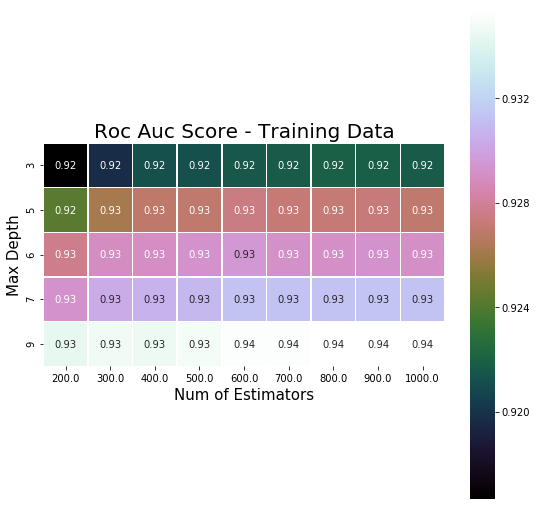

In [35]:
displayhmap = drawgraphs()

pivot_tbl = rndfrst_bow.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

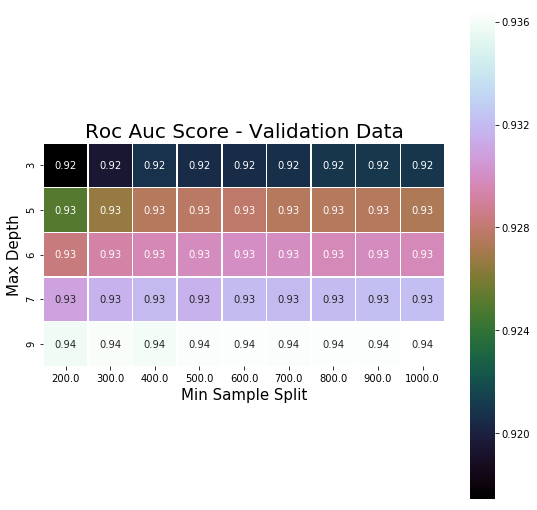

In [36]:
pivot_tbl = rndfrst_bow.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Min Sample Split','Max Depth')

####  Process the actual classifier using Random Forest with no class weights ###
#### Data set has not been balanced using SMOTE ####

In [ ]:
rndfrst_bow.RNDFRST_actClasifier(300,20,50,True)

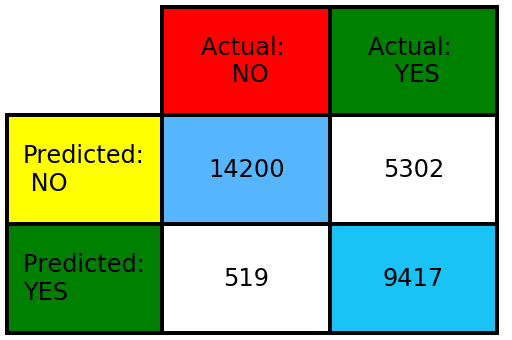

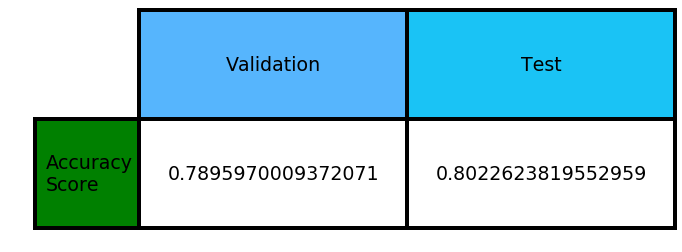

In [130]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_bow.confsnmtxytstpred['tn'] ,rndfrst_bow.confsnmtxytstpred['fn']],[rndfrst_bow.confsnmtxytstpred['fp'],rndfrst_bow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_bow.accuracy_score_val,rndfrst_bow.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_bow_1.dot')  

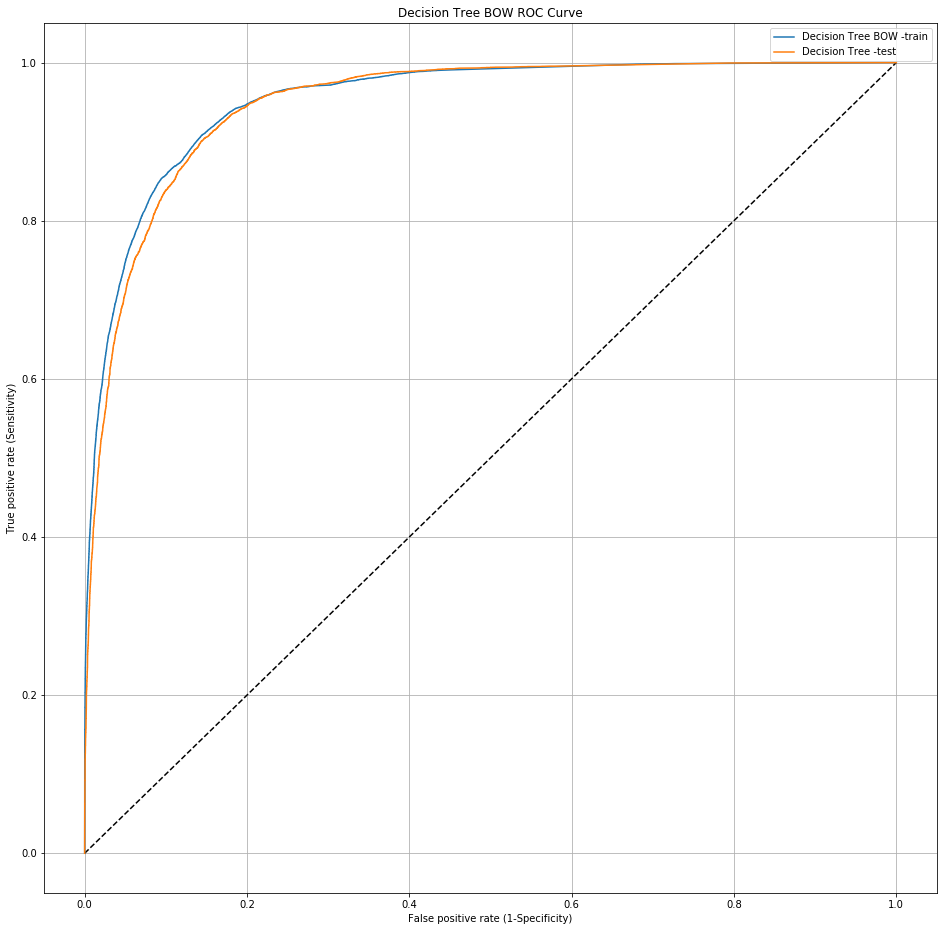

In [131]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_bow.roc_curve_test['fpr_trn'],rndfrst_bow.roc_curve_test['tpr_trn'],\
                            rndfrst_bow.roc_curve_test['fpr'],rndfrst_bow.roc_curve_test['tpr'])

### Process the actual classifier using Random Forest with class weights ###
#### Data set has not been balanced using SMOTE ####

In [ ]:
rndfrst_bow.RNDFRST_actClasifier(800,20,50,False)

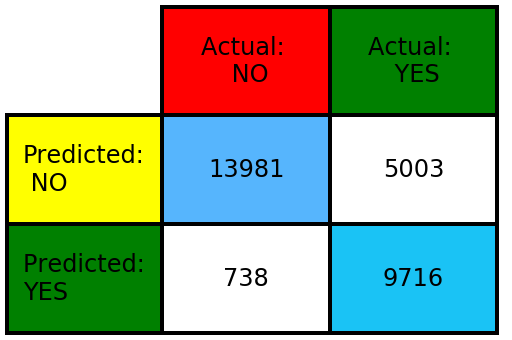

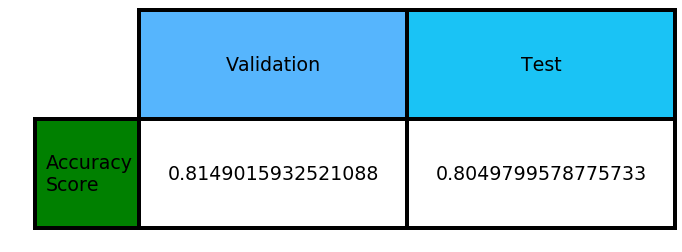

In [133]:

displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_bow.confsnmtxytstpred['tn'] ,rndfrst_bow.confsnmtxytstpred['fn']],[rndfrst_bow.confsnmtxytstpred['fp'],rndfrst_bow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_bow.accuracy_score_val,rndfrst_bow.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_bow_1.dot')  

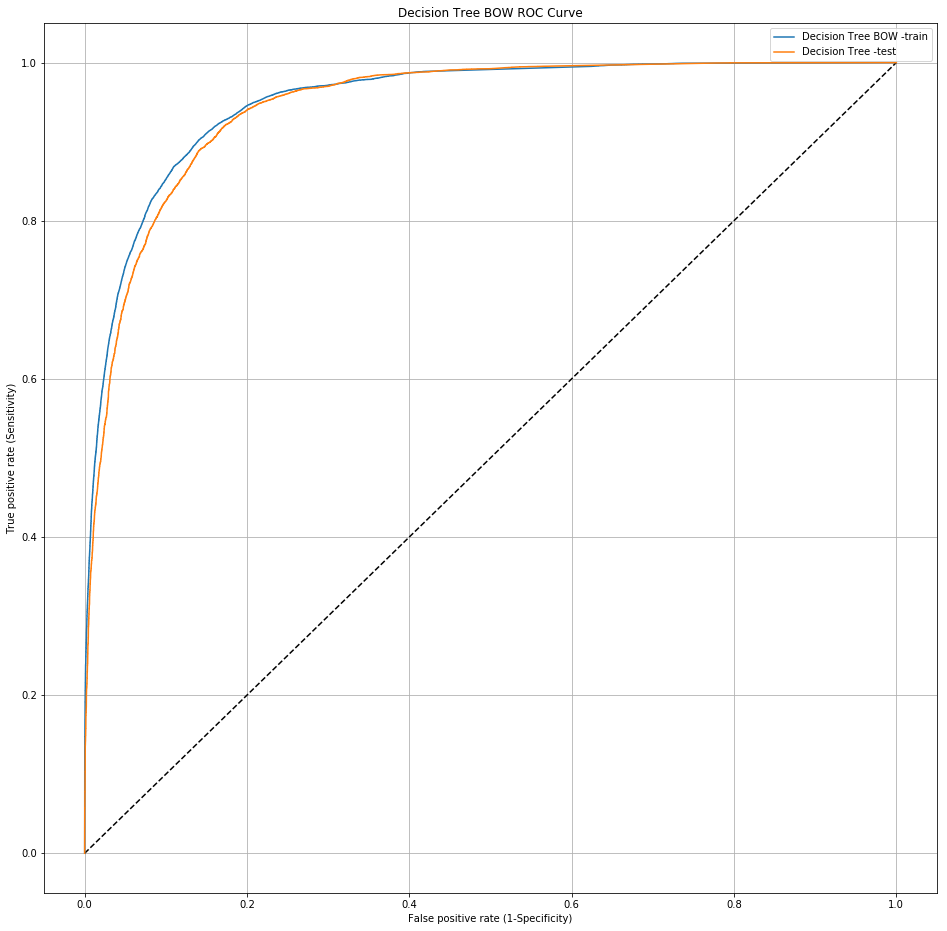

In [40]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Decision Tree BOW ROC Curve'
displaygraph.legnd_1 = 'Decision Tree BOW -train'
displaygraph.legnd_2 = 'Decision Tree -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_bow.roc_curve_test['fpr_trn'],rndfrst_bow.roc_curve_test['tpr_trn'],\
                            rndfrst_bow.roc_curve_test['fpr'],rndfrst_bow.roc_curve_test['tpr'])

### Wordcloud of top 20 important features from<font color='red'> SET 1</font>

#### Wordcloud of top 20 important features from<font color='red'> SET 1</font> with im-balanced dataset ####

In [134]:
rndfrst_clf = rndfrst_bow.getRndFrstClasifier()
feature_names = rndfrst_bow.feat_names
top10_negve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[-20:]
top10_posve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[:20]
feat_pos=[]
feat_neg=[]
features=""
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    features = features + " " + feat_pos[i]
    features = features + " " + feat_neg[i]
    
    i +=1
    
print(features)

 always aftertaste easy almonds well although tasty aroma day artificial also ate nice beans not beef make believe little bite perfect bottles favorite bowl use boxes loves bread find brew delicious brown good caffeine best cake love canned great cannot


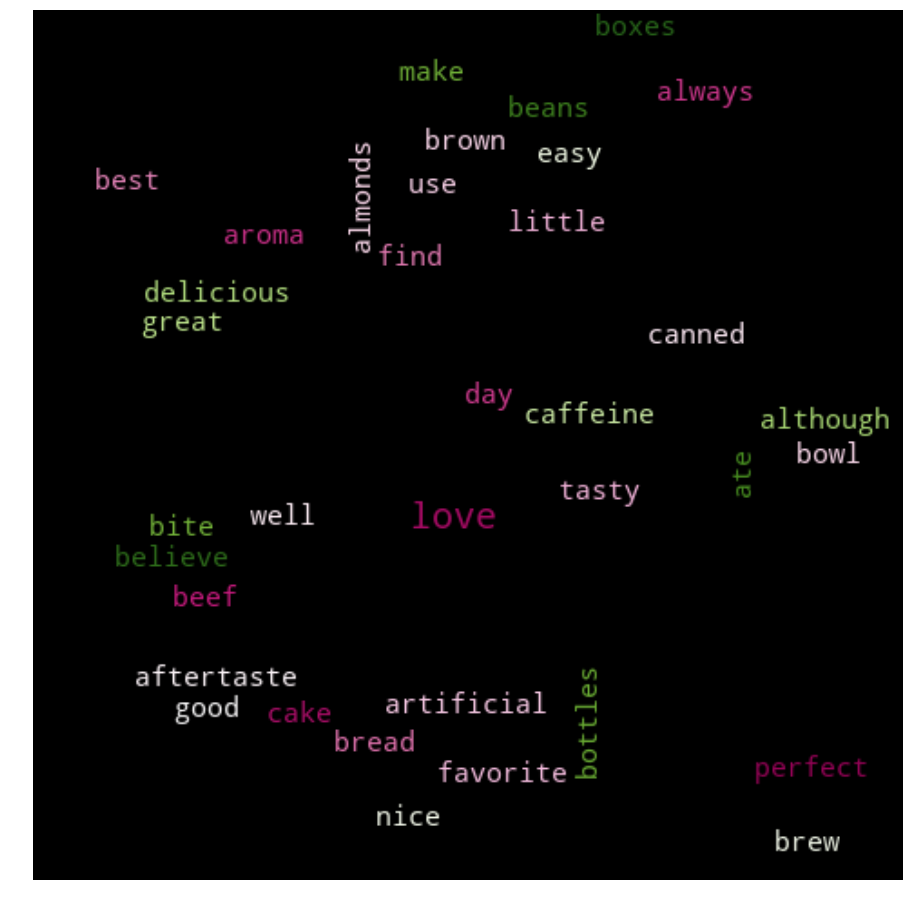

In [135]:
feat = rndfrst_bow.genwrdcldwords()
displaygraph.draw_wordcloud(feat)

#### Wordcloud of top 20 important features from<font color='red'> SET 1</font> with balanced dataset ####

In [136]:
rndfrst_clf = rndfrst_bow.getRndFrstClasifier()
feature_names = rndfrst_bow.feat_names
top10_negve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[-20:]
top10_posve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[:20]
feat_pos=[]
feat_neg=[]
features=""
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    features = features + " " + feat_pos[i]
    features = features + " " + feat_neg[i]
    
    i +=1
    
print(features)

 always aftertaste easy almonds well although tasty aroma day artificial also ate nice beans not beef make believe little bite perfect bottles favorite bowl use boxes loves bread find brew delicious brown good caffeine best cake love canned great cannot


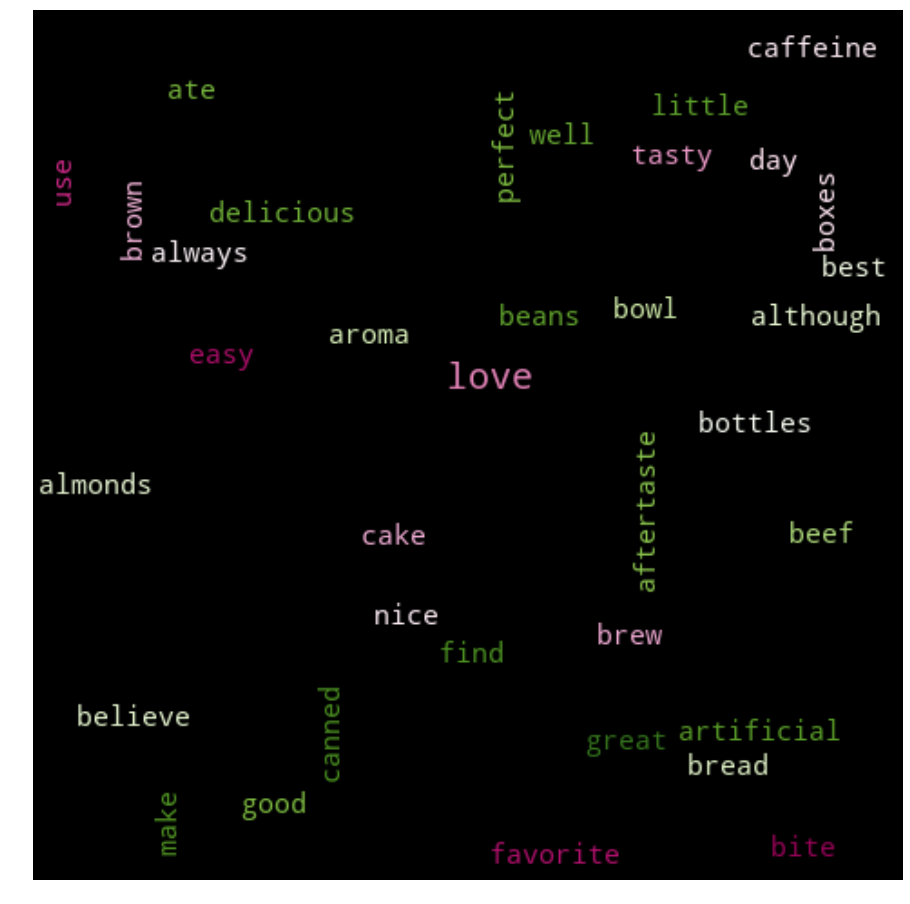

In [137]:
feat = rndfrst_bow.genwrdcldwords()
displaygraph.draw_wordcloud(feat)

### [5.1.2] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>###
#### Data has been balanced using Smote ####

In [0]:
# Please write all the code with proper documentation

In [139]:
rndfrst_tfidf = assign9RndFrst()

In [142]:
rndfrst_tfidf_clf = rndfrst_tfidf.RndFrstClasifier()
rndfrst_tfidf.load_data('TFIDFBAL')
print(rndfrst_tfidf.xtrain.shape)
print(rndfrst_tfidf.xval.shape)

(94272, 500)
(23474, 500)


####  Calculate ROC_AUC curve

In [ ]:
#rndfrst_tfidf.RNDFRST_calcrocaucscore()

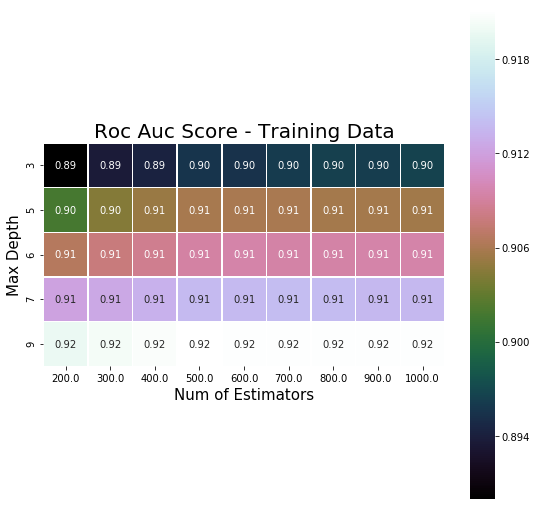

In [45]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_tfidf.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

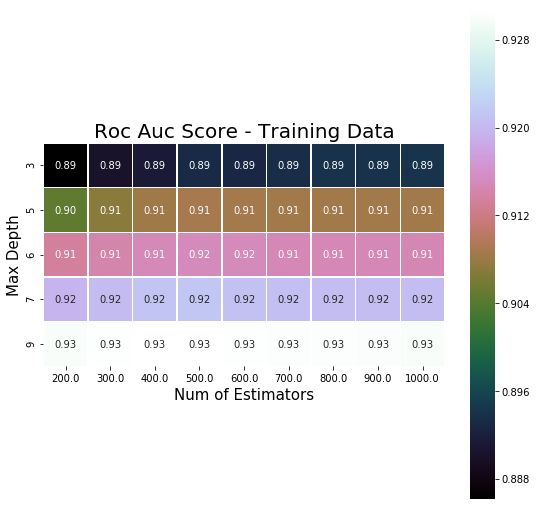

In [46]:
pivot_tbl = rndfrst_tfidf.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

#### Process the actual classifier using Random Forest with class weights ###

In [ ]:
rndfrst_tfidf.RNDFRST_actClasifier(800,20,50,True)

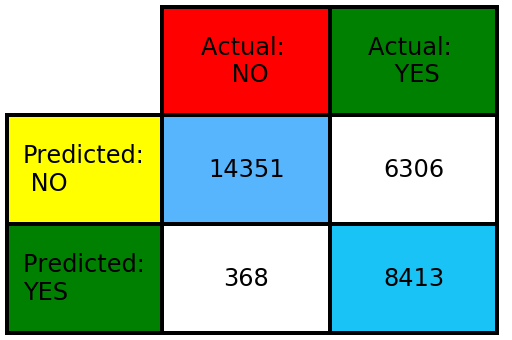

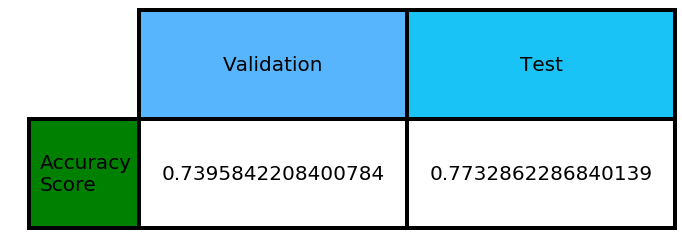

In [49]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_tfidf.confsnmtxytstpred['tn'] ,rndfrst_tfidf.confsnmtxytstpred['fn']],[rndfrst_tfidf.confsnmtxytstpred['fp'],rndfrst_tfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_tfidf.accuracy_score_val,rndfrst_tfidf.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_tfidf_1.dot')  

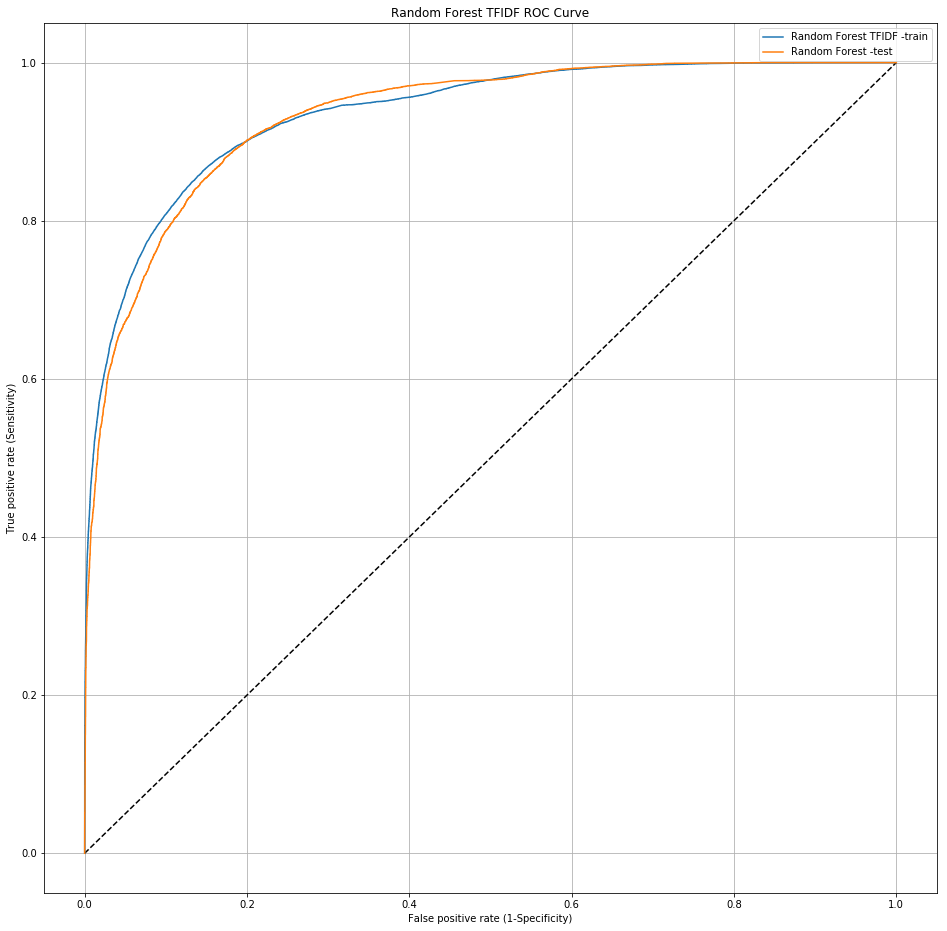

In [48]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest TFIDF ROC Curve'
displaygraph.legnd_1 = 'Random Forest TFIDF -train'
displaygraph.legnd_2 = 'Random Forest -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_tfidf.roc_curve_test['fpr_trn'],rndfrst_tfidf.roc_curve_test['tpr_trn'],\
                            rndfrst_tfidf.roc_curve_test['fpr'],rndfrst_tfidf.roc_curve_test['tpr'])

### Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

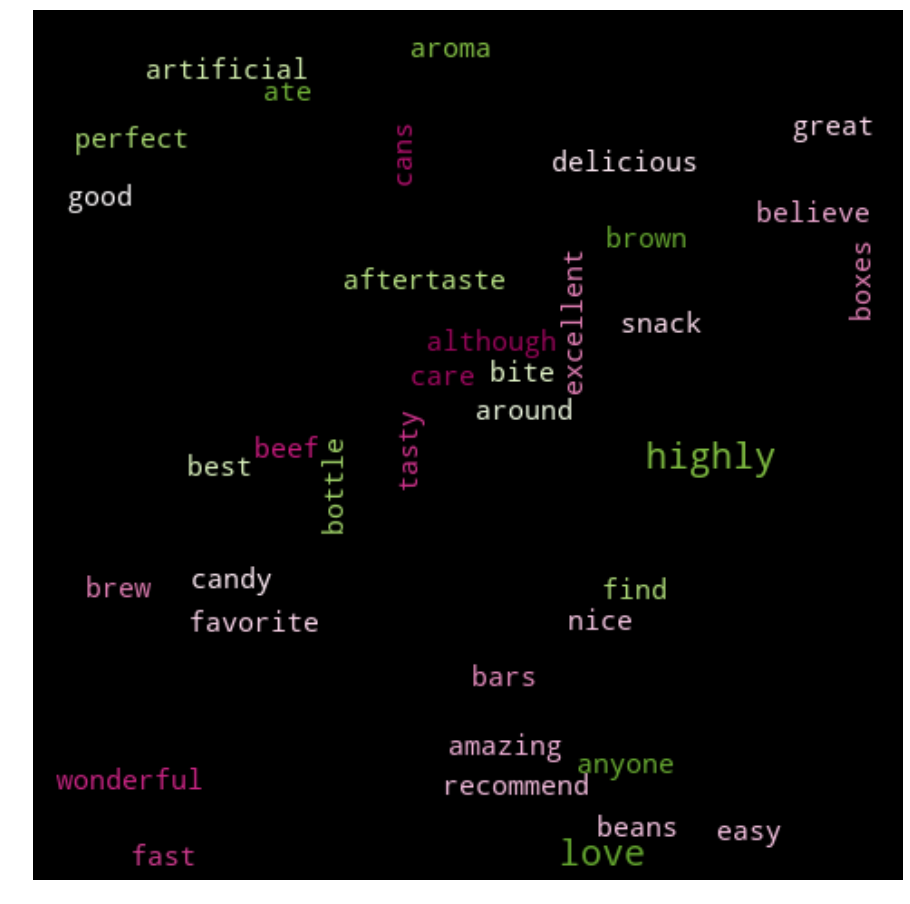

In [144]:
feat = rndfrst_tfidf.genwrdcldwords()
displaygraph.draw_wordcloud(feat)

#### Data has not been balanced ####

In [0]:
# Please write all the code with proper documentation

In [145]:
rndfrst_tfidf_nbal = assign9RndFrst()

In [147]:
rndfrst_tfidfnbal_clf = rndfrst_tfidf_nbal.RndFrstClasifierwNoWts()
rndfrst_tfidf_nbal.load_data('TFIDF')
print(rndfrst_tfidf_nbal.xtrain.shape)
print(rndfrst_tfidf_nbal.xval.shape)

(56174, 500)
(14044, 500)


#### Calculate ROC_AUC curve

In [ ]:
#rndfrst_tfidf_nbal.RNDFRST_calcrocaucscore()

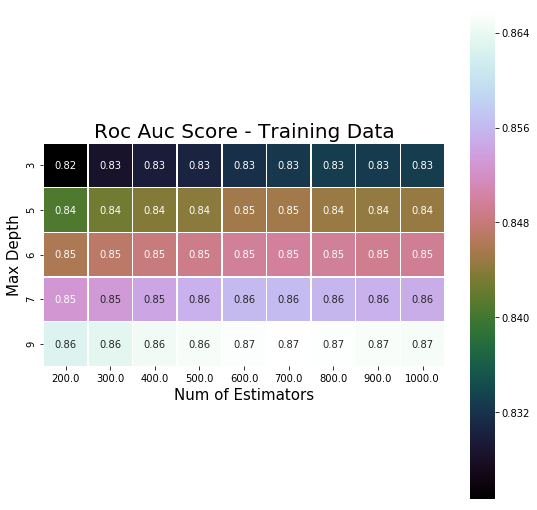

In [53]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_tfidf_nbal.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

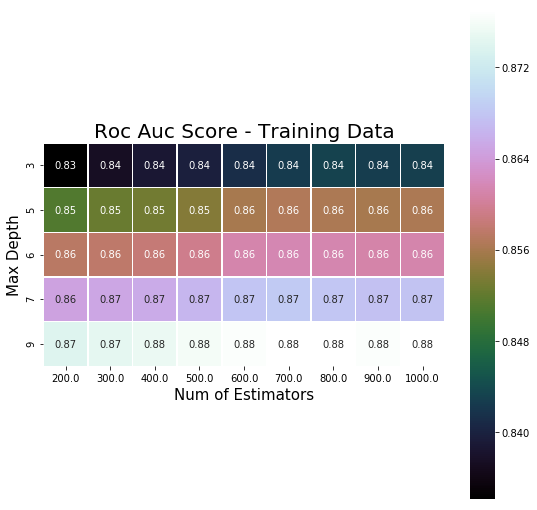

In [54]:
pivot_tbl = rndfrst_tfidf_nbal.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

#### Process the actual classifier using Random Forest###

In [ ]:
rndfrst_tfidf_nbal.RNDFRST_actClasifier(700,20,50,False)

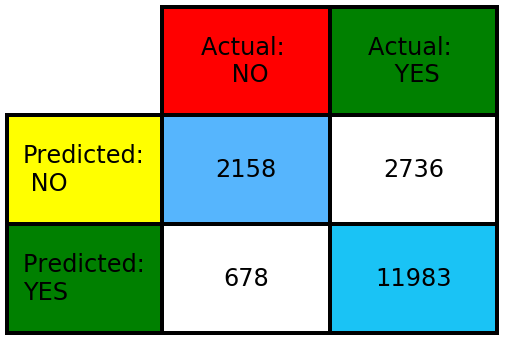

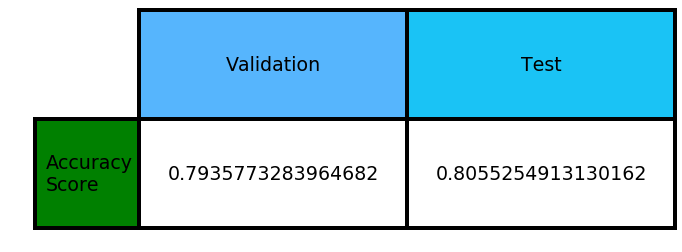

In [56]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_tfidf_nbal.confsnmtxytstpred['tn'] ,rndfrst_tfidf_nbal.confsnmtxytstpred['fn']],[rndfrst_tfidf_nbal.confsnmtxytstpred['fp'],rndfrst_tfidf_nbal.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_tfidf_nbal.accuracy_score_val,rndfrst_tfidf_nbal.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_tfidf_1.dot')  

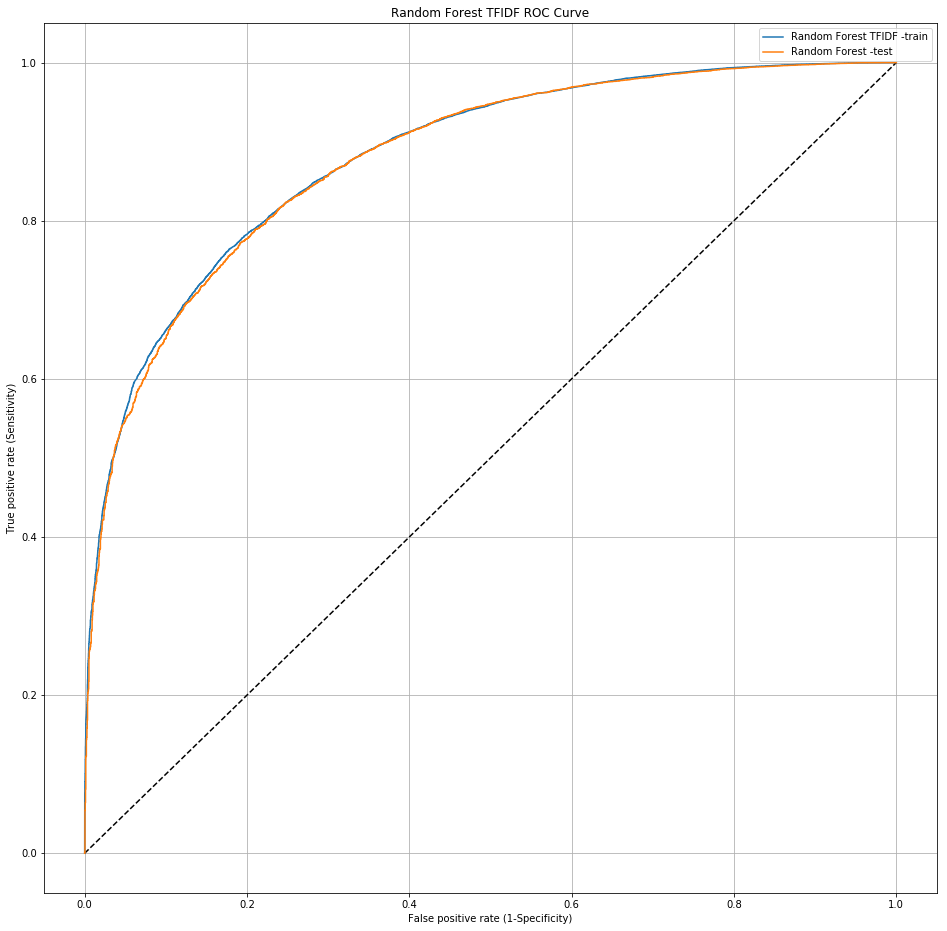

In [57]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest TFIDF ROC Curve'
displaygraph.legnd_1 = 'Random Forest TFIDF -train'
displaygraph.legnd_2 = 'Random Forest -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_tfidf_nbal.roc_curve_test['fpr_trn'],rndfrst_tfidf_nbal.roc_curve_test['tpr_trn'],\
                            rndfrst_tfidf_nbal.roc_curve_test['fpr'],rndfrst_tfidf_nbal.roc_curve_test['tpr'])

#### Wordcloud of top 20 important features from<font color='red'> SET 1</font> with im-balanced dataset ####

In [149]:
rndfrst_clf = rndfrst_tfidf_nbal.getRndFrstClasifier()
feature_names = rndfrst_bow.feat_names
top10_negve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[-20:]
top10_posve = sorted(zip(rndfrst_clf.feature_importances_, feature_names))[:20]
feat_pos=[]
feat_neg=[]
features=""
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    features = features + " " + feat_pos[i]
    features = features + " " + feat_neg[i]
    
    i +=1
    
print(features)

 rich also take alternative making anything night awesome product bags ordered bars available beans decided bit goes bitter would blend recipe bottles looked brand three bread believe breakfast back cake wrong cannot milk care got cats difference chicken nice chips


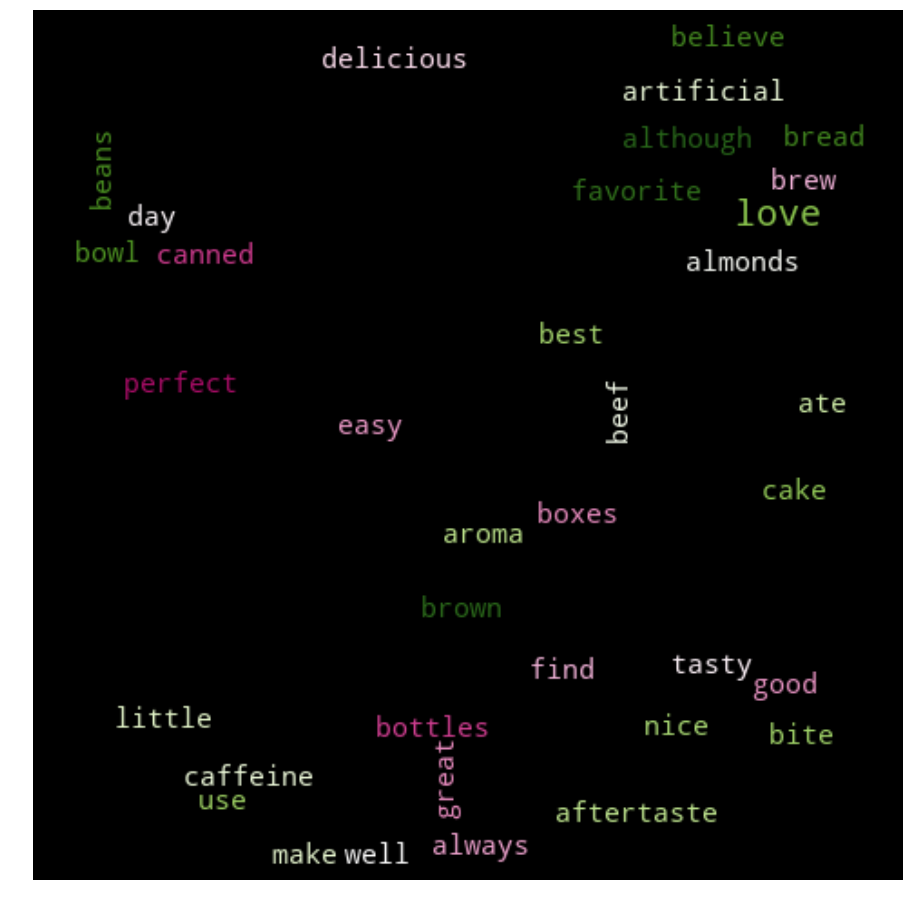

In [150]:
feat = rndfrst_bow.genwrdcldwords()
displaygraph.draw_wordcloud(feat)

### [5.1.3] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

#### Data set has been balanced using SMOTE #### 

In [3]:
rndfrst_avgw2v = assign9RndFrst()
rndfrst_avgw2v.load_data('AVGW2VBAL')
print(rndfrst_avgw2v.xtrain.shape)
print(rndfrst_avgw2v.xval.shape)
rndfrst_avgw2v_clf = rndfrst_avgw2v.RndFrstClasifier()

X_train shape (12762, 50)
y_train shape (12762,)
X_test shape (3190, 50)
y_test shape (3190,)
(10250, 50)
(2512, 50)


In [ ]:
#rndfrst_avgw2v.RNDFRST_calcrocaucscore()

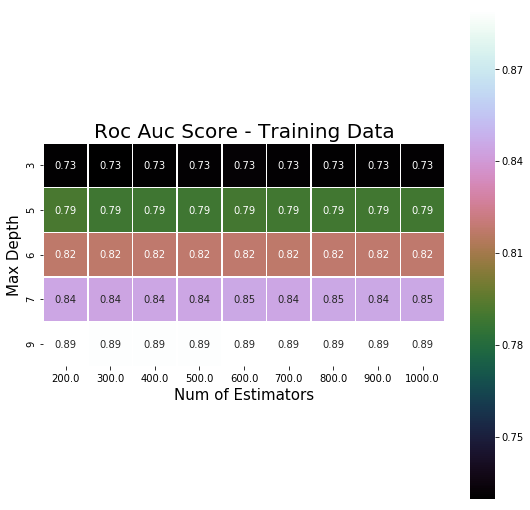

In [5]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_avgw2v.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

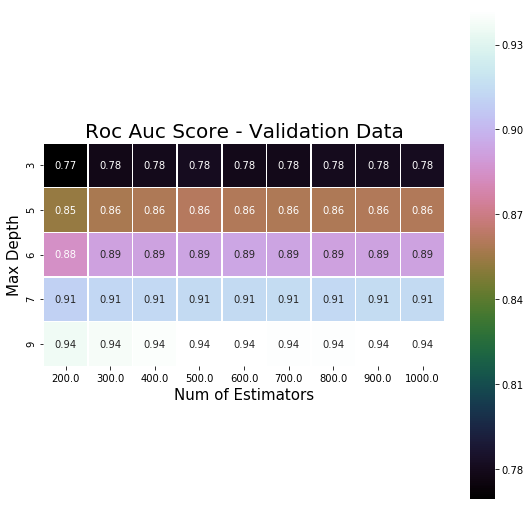

In [6]:
pivot_tbl = rndfrst_avgw2v.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Num of Estimators','Max Depth')

In [ ]:
rndfrst_avgw2v.RNDFRST_actClasifier(1000,20,50,True)

#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_avgw2v_1.dot')  

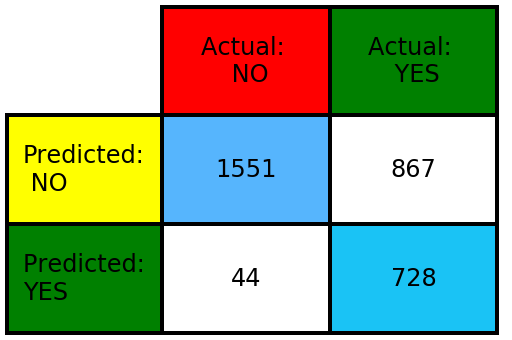

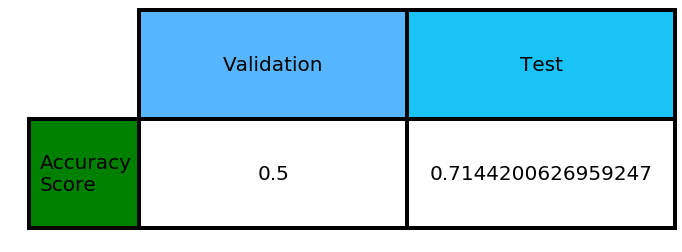

In [15]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_avgw2v.confsnmtxytstpred['tn'] ,rndfrst_avgw2v.confsnmtxytstpred['fn']],[rndfrst_avgw2v.confsnmtxytstpred['fp'],rndfrst_avgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_avgw2v.accuracy_score_val,rndfrst_avgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

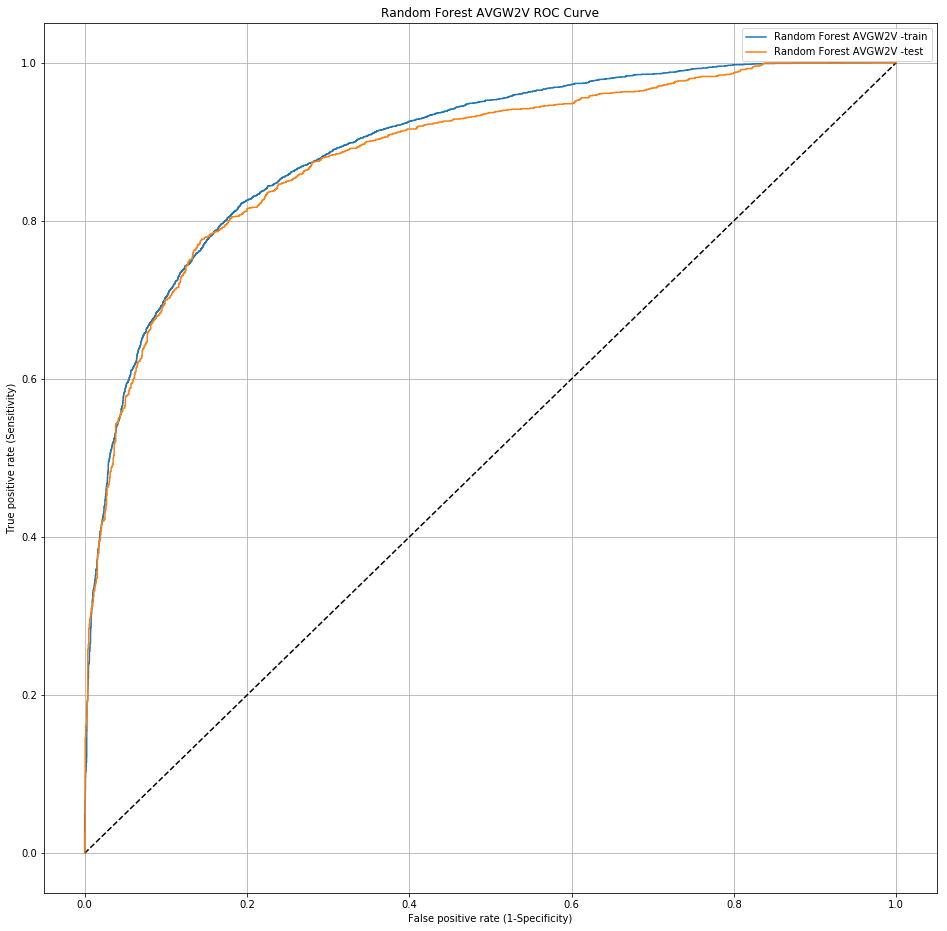

In [14]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest AVGW2V ROC Curve'
displaygraph.legnd_1 = 'Random Forest AVGW2V -train'
displaygraph.legnd_2 = 'Random Forest AVGW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_avgw2v.roc_curve_test['fpr_trn'],rndfrst_avgw2v.roc_curve_test['tpr_trn'],\
                            rndfrst_avgw2v.roc_curve_test['fpr'],rndfrst_avgw2v.roc_curve_test['tpr'])

#### Data set has not been balanced #### 

In [9]:
rndfrst_avgw2v_nbal = assign9RndFrst()
rndfrst_avgw2v_nbal.load_data('AVGW2V')
print(rndfrst_avgw2v_nbal.xtrain.shape)
print(rndfrst_avgw2v_nbal.xval.shape)
rndfrst_avgw2vnbal_clf = rndfrst_avgw2v_nbal.RndFrstClasifier()

X_train shape (7651, 50)
y_train shape (7651,)
X_test shape (1913, 50)
y_test shape (1913,)
(6120, 50)
(1531, 50)


#rndfrst_avgw2v_nbal.RNDFRST_calcrocaucscore()

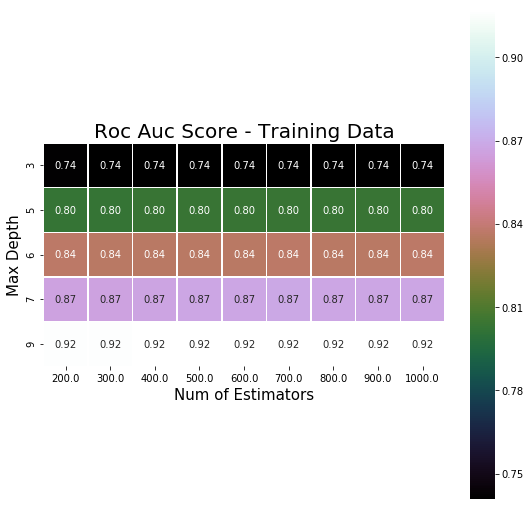

In [11]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_avgw2v_nbal.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

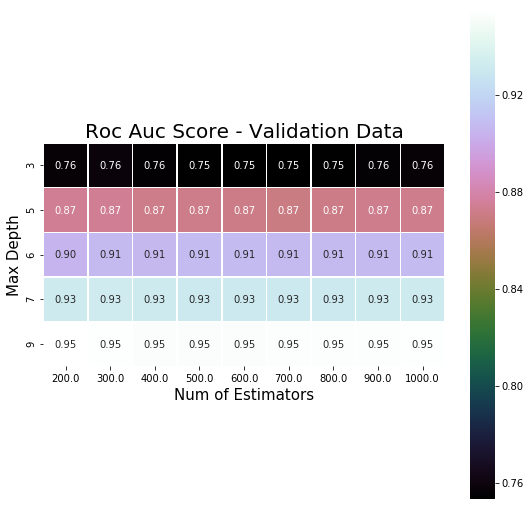

In [12]:
pivot_tbl = rndfrst_avgw2v_nbal.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Num of Estimators','Max Depth')

rndfrst_avgw2v_nbal.RNDFRST_actClasifier(900,15,50,False)

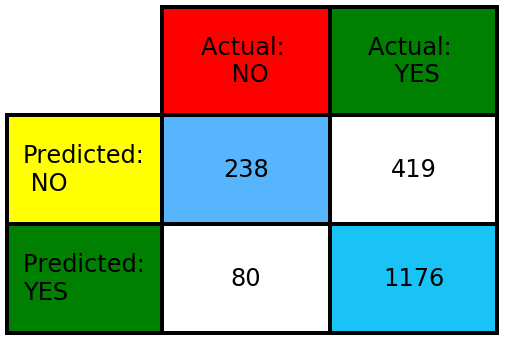

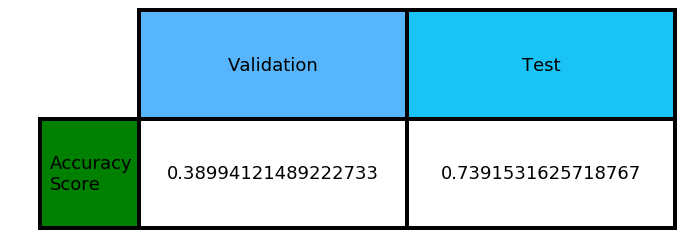

In [17]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_avgw2v_nbal.confsnmtxytstpred['tn'] ,rndfrst_avgw2v_nbal.confsnmtxytstpred['fn']],[rndfrst_avgw2v_nbal.confsnmtxytstpred['fp'],rndfrst_avgw2v_nbal.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_avgw2v_nbal.accuracy_score_val,rndfrst_avgw2v_nbal.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_avgw2v_1.dot') 

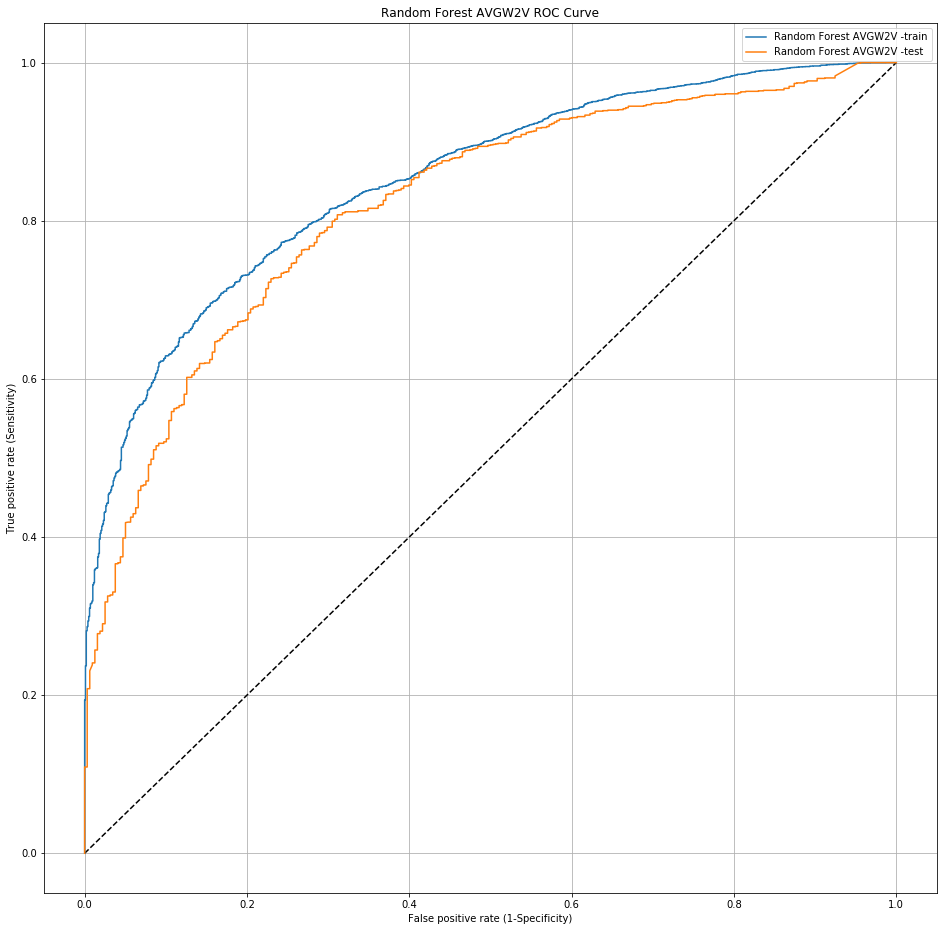

In [18]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest AVGW2V ROC Curve'
displaygraph.legnd_1 = 'Random Forest AVGW2V -train'
displaygraph.legnd_2 = 'Random Forest AVGW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_avgw2v_nbal.roc_curve_test['fpr_trn'],rndfrst_avgw2v_nbal.roc_curve_test['tpr_trn'],\
                            rndfrst_avgw2v_nbal.roc_curve_test['fpr'],rndfrst_avgw2v_nbal.roc_curve_test['tpr'])

### [5.1.4] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

#### Data set has been balanced #### 

In [4]:
rndfrst_wtw2v = assign9RndFrst()
rndfrst_wtw2v.load_data('WTW2VBAL')
print(rndfrst_wtw2v.xtrain.shape)
print(rndfrst_wtw2v.xval.shape)
rndfrst_wtw2v_clf = rndfrst_wtw2v.RndFrstClasifier()

(10250, 50)
(2512, 50)


rndfrst_wtw2v.RNDFRST_calcrocaucscore()

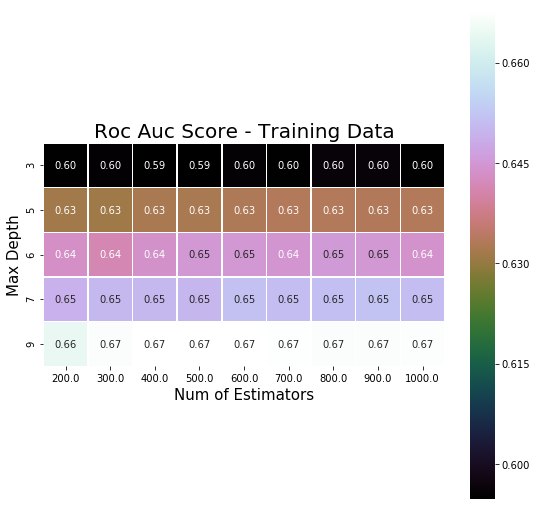

In [6]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_wtw2v.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

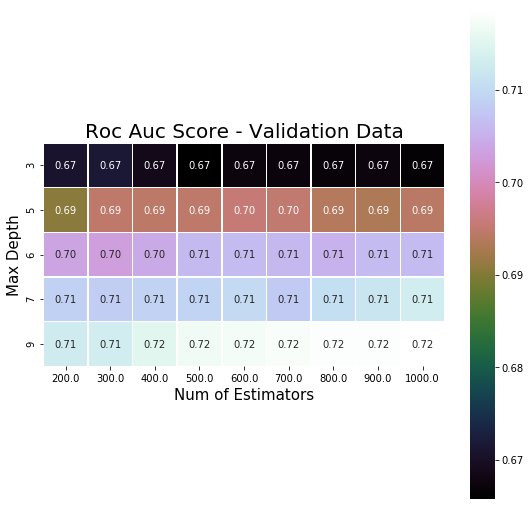

In [7]:
pivot_tbl = rndfrst_wtw2v.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Num of Estimators','Max Depth')

In [ ]:
rndfrst_wtw2v.RNDFRST_actClasifier(700,14,50,True)

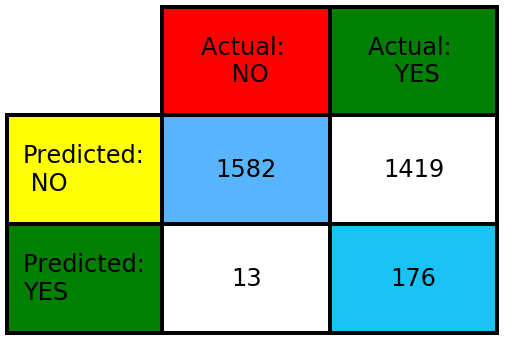

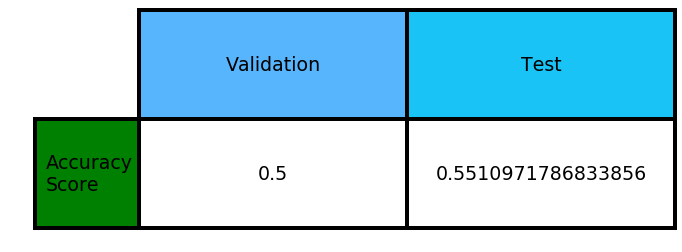

In [9]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_wtw2v.confsnmtxytstpred['tn'] ,rndfrst_wtw2v.confsnmtxytstpred['fn']],[rndfrst_wtw2v.confsnmtxytstpred['fp'],rndfrst_wtw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_wtw2v.accuracy_score_val,rndfrst_wtw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_wtw2v_1.dot')  

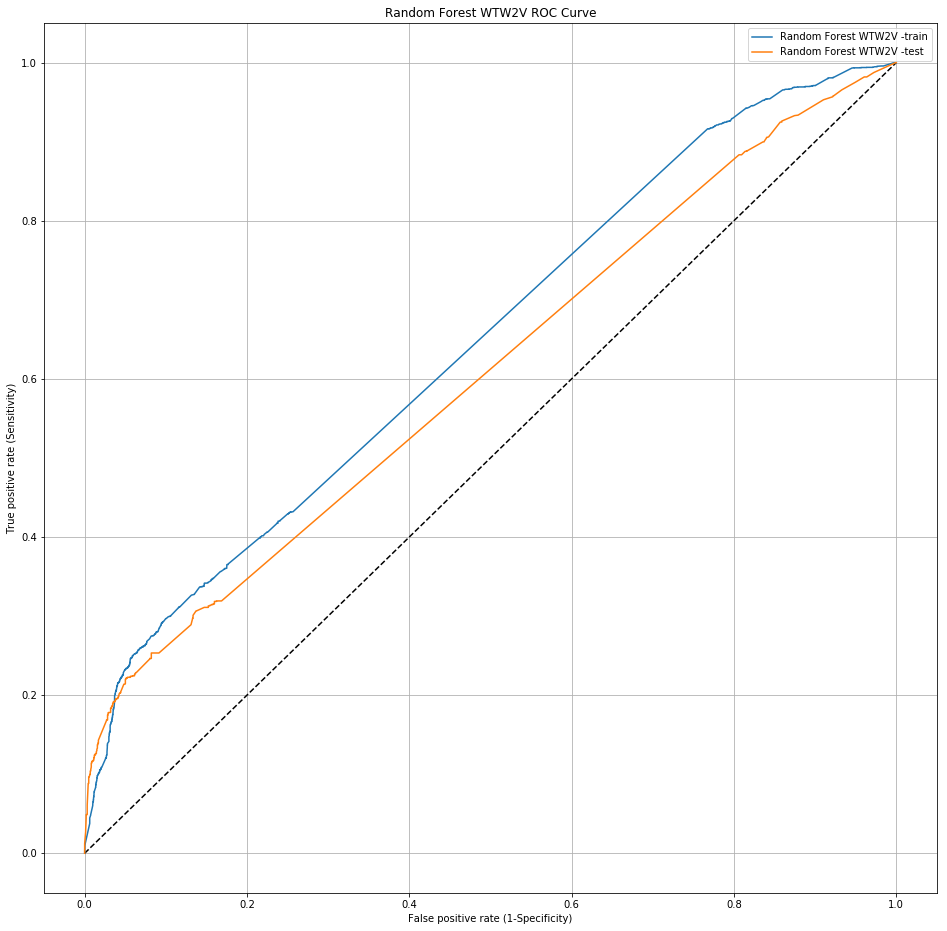

In [10]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest WTW2V ROC Curve'
displaygraph.legnd_1 = 'Random Forest WTW2V -train'
displaygraph.legnd_2 = 'Random Forest WTW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_wtw2v.roc_curve_test['fpr_trn'],rndfrst_wtw2v.roc_curve_test['tpr_trn'],\
                            rndfrst_wtw2v.roc_curve_test['fpr'],rndfrst_wtw2v.roc_curve_test['tpr'])

#### Data set has not been balanced #### 

In [23]:
rndfrst_wtw2v_nbal = assign9RndFrst()
rndfrst_wtw2v_nbal.load_data('WTW2V')
rndfrst_wtw2vnbal_clf = rndfrst_wtw2v_nbal.RndFrstClasifier()

#rndfrst_wtw2v_nbal.RNDFRST_calcrocaucscore()

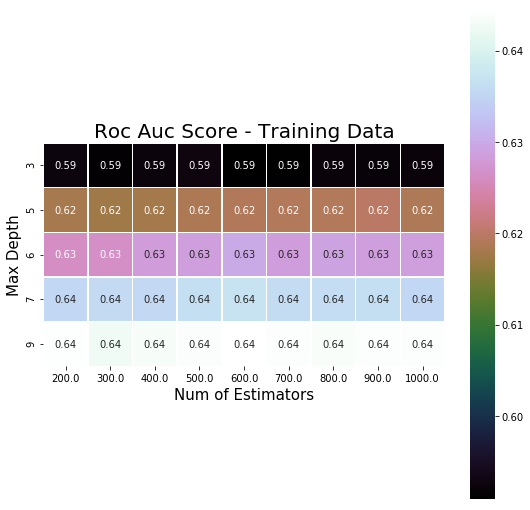

In [26]:
displayhmap = drawgraphs()
pivot_tbl = rndfrst_wtw2v_nbal.rndfrst_hmap_train.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','Num of Estimators','Max Depth')

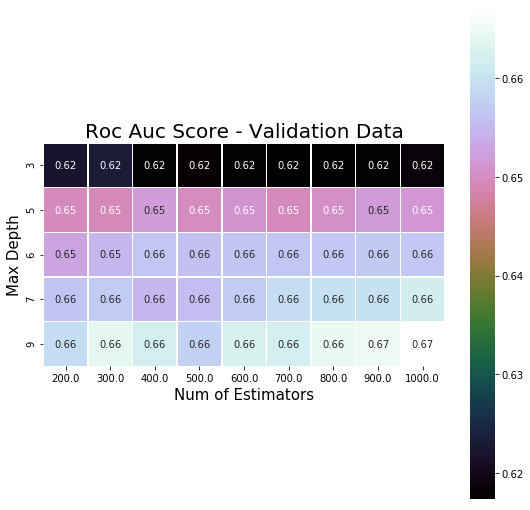

In [27]:
pivot_tbl = rndfrst_wtw2v_nbal.rndfrst_hmap_val.pivot(index='mxdpth',columns='numestim',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','Num of Estimators','Max Depth')

In [ ]:
rndfrst_wtw2v_nbal.RNDFRST_actClasifier(500,15,50,False)

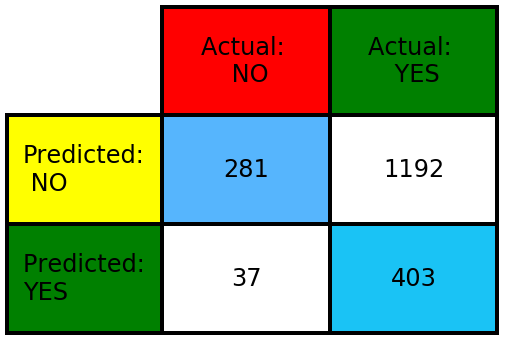

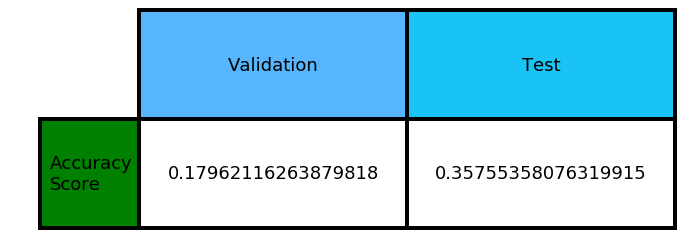

In [29]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[rndfrst_wtw2v_nbal.confsnmtxytstpred['tn'] ,rndfrst_wtw2v_nbal.confsnmtxytstpred['fn']],[rndfrst_wtw2v_nbal.confsnmtxytstpred['fp'],rndfrst_wtw2v_nbal.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[rndfrst_wtw2v_nbal.accuracy_score_val,rndfrst_wtw2v_nbal.accuracy_score_test]]
displaygraph.draw_accscore(data1)
#tree.export_graphviz(dtree.getDTreClasifier(),feature_names=dtree.feat_names,class_names=dtree.y_test,\  
#                    filled=True, rounded=True,,out_file='D:/Graphviz2.38/bin/tree_wtw2v_1.dot') 

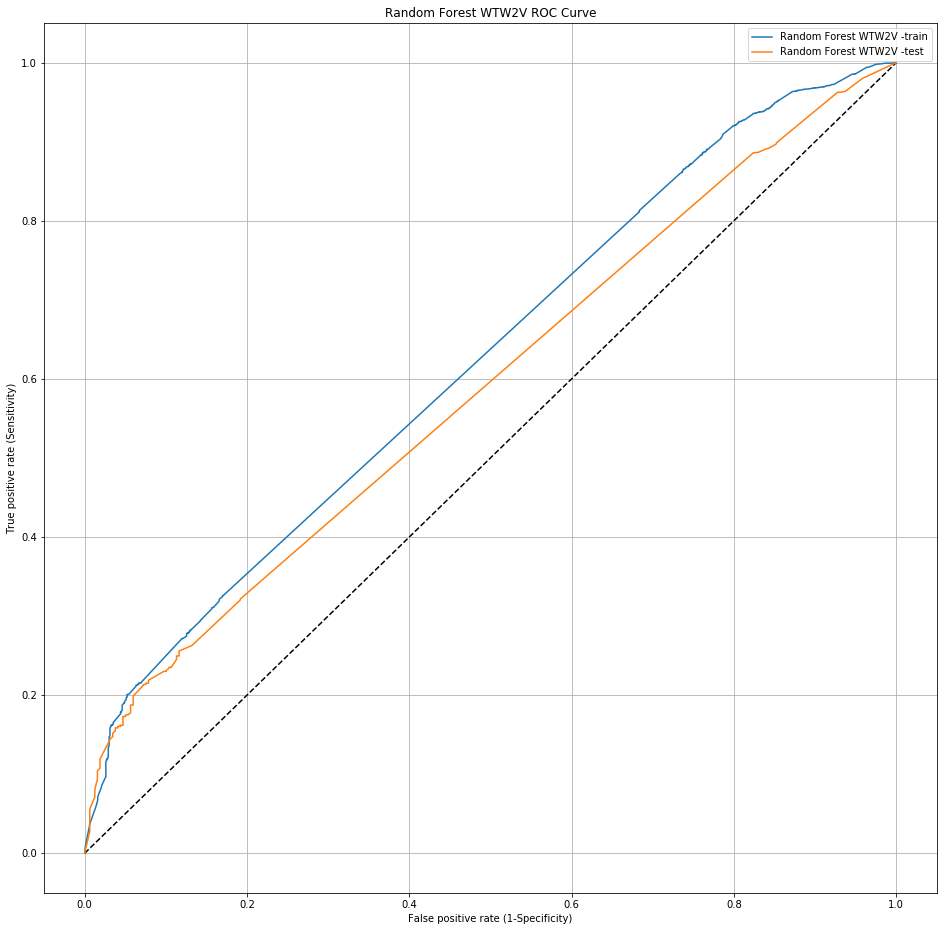

In [30]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Random Forest WTW2V ROC Curve'
displaygraph.legnd_1 = 'Random Forest WTW2V -train'
displaygraph.legnd_2 = 'Random Forest WTW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rndfrst_wtw2v_nbal.roc_curve_test['fpr_trn'],rndfrst_wtw2v_nbal.roc_curve_test['tpr_trn'],\
                            rndfrst_wtw2v_nbal.roc_curve_test['fpr'],rndfrst_wtw2v_nbal.roc_curve_test['tpr'])

## [5.2] Applying GBDT using XGBOOST

### Common code for XGBoost ###

In [34]:
import warnings
warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBClassifier    
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost.sklearn import XGBClassifier

import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle
    
class assign9XGBoost:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])        
        self.xgbst_clf=None
        self.xgbst_max_depth = []
        self.xgbst_n_estimators = []
        self.xgbst_hmap_train = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.xgbst_hmap_val = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.feat_names = []
        self.vectrizer = None
        
    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval
 

    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
		
    @property
    def vectrizer(self):
        return self._vectrizer
    
    @vectrizer.setter
    def vectrizer(self,new_vectrizer):
        self._vectrizer = new_vectrizer
    
    def convtodf(self,lstarr):
        df = pd.DataFrame()        
        df['col1'] = lstarr
        d1 = pd.DataFrame(df.col1.values.tolist())
        print(d1.shape)
        return d1
    
    def load_data(self,mltype):
        #E:\appliedaiacourse\assignments\dblite\dtree\balanced\bowvectorizer\1k
        f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
        if mltype == 'BOW':
            fname1 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/bowvectorizer/y_train'
            fname6 = f1name + '/unbalanced/bowvectorizer/y_test'
            fname7 = f1name + '/unbalanced/bowvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/bowvectorizer/yval'
            fname9 = f1name + '/unbalanced/bowvectorizer/bow_feat'
        elif mltype == 'BOWBAL':
            f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
            fname1 = f1name + '/balanced/bowvectorizer/ppvectscld_x_train'            
            fname2=  f1name + '/balanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/bowvectorizer/y_train'            
            fname6 = f1name + '/balanced/bowvectorizer/y_test'
            fname7 = f1name + '/balanced/bowvectorizer/ytrain'            
            fname8 = f1name + '/balanced/bowvectorizer/yval'
            fname9 = f1name + '/balanced/bowvectorizer/bow_feat'

        elif mltype == 'TFIDF':
            fname1 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfvectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'TFIDFBAL':
            fname1 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfvectorizer/yval'
            fname9 = f1name + '/balanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfwtw2vectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfwtw2vectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2VBAL':
            fname1 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/balanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/balanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2VBAL':
            fname1 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfwtw2vectorizer/yval'
            
            
        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)
            
        if (mltype == 'BOW' or mltype=='TFIDF' or mltype == 'BOWBAL' or mltype == 'TFIDFBAL' or mltype=='WTW2V'):
            with open (fname9, 'rb') as fp:
                self.feat_names = pickle.load(fp)
                
        print('X_train shape', self.X_train.shape)
        print('y_train shape', self.y_train.shape)
        print('X_test shape', self.X_test.shape)
        print('y_test shape', self.y_test.shape)             
        
    def XgBstClasifier(self):
        self.xgbst_clf = XGBClassifier(learning_rate =0.01, n_estimators=100,max_depth=5,\
                                     min_child_weight=1,gamma=0.0,subsample=0.8, colsample_bytree=0.8,\
                                     objective='binary:logistic',nthread=2,verbosity=3,scale_pos_weight=5.1895,seed=42)
        
        return self.xgbst_clf

    def XgBstClasifierNoWts(self):
        self.xgbst_clf = XGBClassifier(learning_rate =0.01, n_estimators=100,max_depth=5,\
                                     min_child_weight=1,gamma=0.0,subsample=0.8, colsample_bytree=0.8,\
                                     objective='binary:logistic',nthread=2,verbosity=3,seed=42)
        
        return self.xgbst_clf    
     
  
    def getXgBstClasifier(self):
        return self.xgbst_clf   
    
    @property
    def xgbst_clf(self):
        return self._xgbst_clf
    
    @xgbst_clf.setter
    def xgbst_clf(self,new_xgbst_clf):
        self._xgbst_clf = new_xgbst_clf

    #set max_depth parameter for classifier
    def setmaxdepthparm(self,prmval):
        params = {'max_depth': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 
      
    #set number of estimators    
    def setnestparm(self,prmval):
        params = {'n_estimators': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 

    # set learning rate 
    def setlearnrateparm(self,prmval):
        params = {'learning_rate': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf  
    
    # set gamma
    def setgammaparm(self,prmval):
        params = {'gamma': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 

    
    def XGBST_calcrocaucscore(self):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process             
        """
        """
            this is  for BOW
        max_depth =  [3, 5, 6, 7, 9, 12, 14, 15, 20,26,30,35,40,50]
        mnsmp_split = [5,10,25,50,75,100,250,500,600,700,800,900,1000]
        
        min_sample_split = [2, 5, 10, 30, 50, 75, 100]
        max_depth = [2, 5, 7, 9, 10, 12, 14, 15]
        """
        self.xgbst_hmap_train = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.xgbst_hmap_val = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        
        n_est = [200,300,400,500,600,700,800,900,1000]
        
        learn_rate = [1e-3, 1e-2, 0.1,1]
        
        #trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        #val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        rocaucval_trn = 0.0
        rocaucval_val = 0.0       
     

        for nest in n_est :

            # set number of estimators param for classifier
            self.setnestparm(nest)

            # loop thru learning rate for the classifier
            for lrate in learn_rate:

                    #set learning rate for the classifier
                    self.setlearnrateparm(lrate)

                    # fit the x-train model            
                    #(self.xgbst_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
                    (self.xgbst_clf).fit(self.xtrain,self.ytrain)

                    my_calib = CalibratedClassifierCV((self.xgbst_clf),method='sigmoid',cv='prefit')
                    my_calib.fit(self.xtrain,self.ytrain)

                    self.yprdprobatrn =  ((self.xgbst_clf)).predict_proba(self.xtrain)[:,1]            
                    rocaucval_trn = roc_auc_score(self.ytrain,self.yprdprobatrn)


                    #fit the validation model
                    (self.xgbst_clf).fit(self.xval,self.yval)

                    my_calib_1 = CalibratedClassifierCV((self.xgbst_clf),method='sigmoid',cv='prefit')
                    my_calib_1.fit(self.xval,self.yval)

                    self.yprdprobaval =  ((self.xgbst_clf)).predict_proba(self.xval)[:,1]
                    rocaucval_val = roc_auc_score(self.yval,self.yprdprobaval)

                    #print('max depth {0}.min samp split {1} probability and roc auc score generation for training validation data complete..'.format(mxdpth,mnsmpsplt))


            (self.xgbst_hmap_val)= (self.xgbst_hmap_val).append([{'nest': nest,'learnrate':lrate,'rocaucscore': rocaucval_val}])

            #great python appending a row to dataframe doesnt happen implace you need to store the output back
            (self.xgbst_hmap_train)= (self.xgbst_hmap_train).append([{'nest': nest,'learnrate':lrate,'rocaucscore': rocaucval_trn}])                


        print('Function exiting...')

    def XGBST_actClasifier(self,n_ests,max_dpth,lrngrte,fitsmpwts=False):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process            
        """
        
        if fitsmpwts == True :
            train_clf = self.XgBstClasifier()
            test_clf = self.XgBstClasifier()            
        else:
            train_clf = self.XgBstClasifierNoWts()
            test_clf = self.XgBstClasifierNoWts()

        params = {'max_depth': max_dpth}
        (train_clf).set_params(**params) 
        
        params = {'learning_rate': lrngrte}
        (train_clf).set_params(**params) 

        params = {'n_estimators': n_ests}
        (train_clf).set_params(**params)
      

        (train_clf).fit(self.xtrain,self.ytrain)
                
        #Calibratedcv for predicting probabilities        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        
        # fit train with sample weights
        my_calib_1.fit(self.xtrain,self.ytrain)
        
        # predict probabilites using predict_proba  from calibratedcv
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        
        # compute the false-positive r, true positive rates and thresholds
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # cailbratedCv for validation dataset
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        #fit the validation dataset with sample weights
        my_calib_2.fit(self.xval,self.yval)
        
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)        
        
        # calculate accuracy_score for validation dataset
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        #setting parameters for the test classifier
        params = {'max_depth': max_dpth}
        (test_clf).set_params(**params) 

        params = {'learning_rate': lrngrte}
        (test_clf).set_params(**params)        
        
        params = {'n_estimators': n_ests}
        (test_clf).set_params(**params)        
     
        (test_clf).fit(self.X_train,self.y_train)        
                
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        
        #predicting probabilities for X_test setweights test sample weights
        my_calib.fit(self.X_test,self.y_test)        
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print('***X_test predict',self.test_predict)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        #calculate accuracy_score for X_test
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report for X_test
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        
        print('*** predict probabilities***',self.ytst_predprob_actclf)
              
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.xgbst_clf = test_clf         
        
    def genwrdcldwords(self):
        
        top10_negve = sorted(zip((self.xgbst_clf).feature_importances_, self.feat_names))[-20:]
        top10_posve = sorted(zip((self.xgbst_clf).feature_importances_, self.feat_names))[:20]
            
        feat_pos=[]
        feat_neg=[]
            
        features=""
            
        for coef,feat in (top10_negve):    
            feat_pos.append(feat)

        for cef,feat in (top10_posve):   
            feat_neg.append(feat)

        i=0
        while i< int(len(feat_pos)):
            feat_item=[]
            features = features + " " + feat_pos[i]
            features = features + " " + feat_neg[i]

            i +=1
        return features

### Common code for calculating ROC_AUC Scores ###

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBClassifier    
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost.sklearn import XGBClassifier

import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle
    
class assign9XGBoost:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])        
        self.xgbst_clf=None
        self.xgbst_max_depth = []
        self.xgbst_n_estimators = []
        self.xgbst_hmap_train = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.xgbst_hmap_val = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.feat_names = []
        self.vectrizer = None
        self.mdlname =None 

    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval
 

    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
		
    @property
    def vectrizer(self):
        return self._vectrizer
    
    @vectrizer.setter
    def vectrizer(self,new_vectrizer):
        self._vectrizer = new_vectrizer
    
    def convtodf(self,lstarr):
        df = pd.DataFrame()        
        df['col1'] = lstarr
        d1 = pd.DataFrame(df.col1.values.tolist())
        print(d1.shape)
        return d1

    def setmdl(self, model):
        self.mdlname =  model

    def getmdl(self):
        return self.mdlname

    def load_data(self,mltype):
        #E:\appliedaiacourse\assignments\dblite\dtree\balanced\bowvectorizer\1k
        f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
        if mltype == 'BOW':
            fname1 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/bowvectorizer/y_train'
            fname6 = f1name + '/unbalanced/bowvectorizer/y_test'
            fname7 = f1name + '/unbalanced/bowvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/bowvectorizer/yval'
            fname9 = f1name + '/unbalanced/bowvectorizer/bow_feat'
        elif mltype == 'BOWBAL':
            f1name = 'E:/appliedaicourse/assignments/dblite/1kpts'
            fname1 = f1name + '/balanced/bowvectorizer/ppvectscld_x_train'            
            fname2=  f1name + '/balanced/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/bowvectorizer/y_train'            
            fname6 = f1name + '/balanced/bowvectorizer/y_test'
            fname7 = f1name + '/balanced/bowvectorizer/ytrain'            
            fname8 = f1name + '/balanced/bowvectorizer/yval'
            fname9 = f1name + '/balanced/bowvectorizer/bow_feat'

        elif mltype == 'TFIDF':
            fname1 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfvectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'TFIDFBAL':
            fname1 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfvectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfvectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfvectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfvectorizer/yval'
            fname9 = f1name + '/balanced/tfidfvectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/unbalanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/unbalanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/unbalanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/unbalanced/tfidfwtw2vectorizer/yval'
            fname9 = f1name + '/unbalanced/tfidfwtw2vectorizer/tfidf_feat'
            
        elif mltype == 'AVGW2VBAL':
            fname1 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/avgw2vectorizer/y_train'
            fname6 = f1name + '/balanced/avgw2vectorizer/y_test'
            fname7 = f1name + '/balanced/avgw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/avgw2vectorizer/yval'        
        elif mltype == 'WTW2VBAL':
            fname1 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/balanced/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/balanced/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/balanced/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/balanced/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/balanced/tfidfwtw2vectorizer/yval'
            
            
        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)
            
        if (mltype == 'BOW' or mltype=='TFIDF' or mltype == 'BOWBAL' or mltype == 'TFIDFBAL' or mltype=='WTW2V'):
            with open (fname9, 'rb') as fp:
                self.feat_names = pickle.load(fp)
        """       
        print('X_train shape', self.X_train.shape)
        print('y_train shape', self.y_train.shape)
        print('X_test shape', self.X_test.shape)
        print('y_test shape', self.y_test.shape)             
        """
    def XgBstClasifier(self):
        self.xgbst_clf = XGBClassifier(learning_rate =0.01, n_estimators=100,max_depth=5,\
                                     min_child_weight=1,gamma=0.0,subsample=0.8, colsample_bytree=0.8,\
                                     objective='binary:logistic',nthread=3,verbosity=3,scale_pos_weight=5.1895,seed=42)
        
        return self.xgbst_clf

    def XgBstClasifierNoWts(self):
        self.xgbst_clf = XGBClassifier(learning_rate =0.01, n_estimators=100,max_depth=5,\
                                     min_child_weight=1,gamma=0.0,subsample=0.8, colsample_bytree=0.8,\
                                     objective='binary:logistic',nthread=3,verbosity=3,seed=42)
        
        return self.xgbst_clf    
     
  
    def getXgBstClasifier(self):
        return self.xgbst_clf   
    
    @property
    def xgbst_clf(self):
        return self._xgbst_clf
    
    @xgbst_clf.setter
    def xgbst_clf(self,new_xgbst_clf):
        self._xgbst_clf = new_xgbst_clf

    #set max_depth parameter for classifier
    def setmaxdepthparm(self,prmval):
        params = {'max_depth': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 
      
    #set number of estimators    
    def setnestparm(self,prmval):
        params = {'n_estimators': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 

    # set learning rate 
    def setlearnrateparm(self,prmval):
        params = {'learning_rate': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf  
    
    # set gamma
    def setgammaparm(self,prmval):
        params = {'gamma': prmval}
        (self.xgbst_clf).set_params(**params)
        return self.xgbst_clf 

    
    def XGBST_calcrocaucscore(self):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process             
        """
        """
            this is  for BOW
        max_depth =  [3, 5, 6, 7, 9, 12, 14, 15, 20,26,30,35,40,50]
        mnsmp_split = [5,10,25,50,75,100,250,500,600,700,800,900,1000]
        
        min_sample_split = [2, 5, 10, 30, 50, 75, 100]
        max_depth = [2, 5, 7, 9, 10, 12, 14, 15]
        """
        self.xgbst_hmap_train = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        self.xgbst_hmap_val = pd.DataFrame(columns=('nestimators','learnrate','rocaucscore'))
        
        n_est = [200,300,400,500,600,700,800,900,1000]
        
        learn_rate = [1e-3, 1e-2, 0.1,1]
        
        #trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        #val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        rocaucval_trn = 0.0
        rocaucval_val = 0.0       
     

        for nest in n_est :

            # set number of estimators param for classifier
            self.setnestparm(nest)

            # loop thru learning rate for the classifier
            for lrate in learn_rate:

                    #set learning rate for the classifier
                    self.setlearnrateparm(lrate)

                    # fit the x-train model            
                    #(self.xgbst_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
                    if self.getmdl() == 'WTW2V' :
                        self.xtrain = pd.DataFrame(self.xtrain)
                        
                    (self.xgbst_clf).fit(self.xtrain,self.ytrain)


                    my_calib = CalibratedClassifierCV((self.xgbst_clf),method='sigmoid',cv='prefit')
                    my_calib.fit(self.xtrain,self.ytrain)

                    self.yprdprobatrn =  ((self.xgbst_clf)).predict_proba(self.xtrain)[:,1]            
                    rocaucval_trn = roc_auc_score(self.ytrain,self.yprdprobatrn)


                    #fit the validation model
                    (self.xgbst_clf).fit(self.xval,self.yval)

                    my_calib_1 = CalibratedClassifierCV((self.xgbst_clf),method='sigmoid',cv='prefit')
                    my_calib_1.fit(self.xval,self.yval)

                    self.yprdprobaval =  ((self.xgbst_clf)).predict_proba(self.xval)[:,1]
                    rocaucval_val = roc_auc_score(self.yval,self.yprdprobaval)

                    #print('max depth {0}.min samp split {1} probability and roc auc score generation for training validation data complete..'.format(mxdpth,mnsmpsplt))

                    self.xgbst_hmap_val = (self.xgbst_hmap_val).append([{'nestimators': nest,'learnrate':lrate,'rocaucscore': rocaucval_val}])
                    print(nest,lrate,rocaucval_val, self.xgbst_hmap_val)
                    #great python appending a row to dataframe doesnt happen implace you need to store the output back
                    self.xgbst_hmap_train = (self.xgbst_hmap_train).append([{'nestimators': nest,'learnrate':lrate,'rocaucscore': rocaucval_trn}])                
                    print(nest,lrate,rocaucval_trn,self.xgbst_hmap_train)

        fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/'+ self.getmdl() +'_xgbst_hmap_cval.out'
        with open(fname, 'wb') as fp:
            pickle.dump(self.xgbst_hmap_val, fp)

        fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/'+ self.getmdl() +'_xgbst_hmap_train.out'
        with open(fname, 'wb') as fp:
            pickle.dump(self.xgbst_hmap_train, fp)

        print('Function exiting...')

    def XGBST_actClasifier(self,n_ests,max_dpth,lrngrte,fitsmpwts=False):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process            
        """
        
        if fitsmpwts == True :
            train_clf = self.XgBstClasifier()
            test_clf = self.XgBstClasifier()            
        else:
            train_clf = self.XgBstClasifierNoWts()
            test_clf = self.XgBstClasifierNoWts()

        params = {'max_depth': max_dpth}
        (train_clf).set_params(**params) 
        
        params = {'learning_rate': lrngrte}
        (train_clf).set_params(**params) 

        params = {'n_estimators': n_ests}
        (train_clf).set_params(**params)
      

        (train_clf).fit(self.xtrain.as_matrix(),self.ytrain)
                
        #Calibratedcv for predicting probabilities        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        
        # fit train with sample weights
        my_calib_1.fit(self.xtrain,self.ytrain)
        
        # predict probabilites using predict_proba  from calibratedcv
        self.ytrn_predprob_actclf = ((self.xgbst_clf)).predict_proba(self.xtrain.as_matrix(),validate_features=False)[:,1]
        
        # compute the false-positive r, true positive rates and thresholds
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # cailbratedCv for validation dataset
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        #fit the validation dataset with sample weights
        my_calib_2.fit(self.xval.as_matrix(),self.yval)
        
        # predict the labels for validation
        self.predicted = ((self.xgbst_clf)).predict(self.xval.as_matrix(),validate_features=False)        
        
        # calculate accuracy_score for validation dataset
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        #setting parameters for the test classifier
        params = {'max_depth': max_dpth}
        (test_clf).set_params(**params) 

        params = {'learning_rate': lrngrte}
        (test_clf).set_params(**params)        
        
        params = {'n_estimators': n_ests}
        (test_clf).set_params(**params)        
     
        (test_clf).fit(self.X_train.as_matrix(),self.y_train)        
                
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        
        #predicting probabilities for X_test setweights test sample weights
        my_calib.fit(self.X_test,self.y_test)        
        
        # predict xtest labels        
        self.test_predict = ((self.xgbst_clf)).predict(self.X_test.as_matrix(),validate_features=False)

        print('***X_test predict',self.test_predict)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        #calculate accuracy_score for X_test
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report for X_test
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = ((self.xgbst_clf)).predict_proba(self.X_test.as_matrix(),validate_features=False)[:,1]
        
        print('*** predict probabilities***',self.ytst_predprob_actclf)
              
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.xgbst_clf = test_clf         
        
    def genwrdcldwords(self):
        
        top10_negve = sorted(zip((self.xgbst_clf).feature_importances_, self.feat_names))[-20:]
        top10_posve = sorted(zip((self.xgbst_clf).feature_importances_, self.feat_names))[:20]
            
        feat_pos=[]
        feat_neg=[]
            
        features=""
            
        for coef,feat in (top10_negve):    
            feat_pos.append(feat)

        for cef,feat in (top10_posve):   
            feat_neg.append(feat)

        i=0
        while i< int(len(feat_pos)):
            feat_item=[]
            features = features + " " + feat_pos[i]
            features = features + " " + feat_neg[i]

            i +=1
        return features

if __name__ == "__main__":


    xgbst = assign9XGBoost()
    
    xgbst.load_data('BOWBAL')    
    xgbst.setmdl('BOWBAL')
    print('BOWBAL')
    xgbst_clf = xgbst.XgBstClasifier()
    xgbst.XGBST_calcrocaucscore()
   
    xgbst.load_data('BOW')    
    xgbst.setmdl('BOW')
    print('BOW')
    xgbst_clf = xgbst.XgBstClasifier()
    xgbst.XGBST_calcrocaucscore()

    xgbst.load_data('TFIDFBAL')    
    xgbst.setmdl('TFIDFBAL')
    print('TFIDFBAL')
    xgbst_clf = xgbst.XgBstClasifier()
    xgbst.XGBST_calcrocaucscore()

    xgbst.load_data('TFIDF')    
    xgbst.setmdl('TFIDF')
    print('TFIDF')
    xgbst_clf = xgbst.XgBstClasifierNoWts()
    xgbst.XGBST_calcrocaucscore()

    xgbst.load_data('AVGW2VBAL')    
    xgbst.setmdl('AVGW2VBAL')
    print('AVGW2VBAL')
    xgbst_clf = xgbst.XgBstClasifier()
    xgbst.XGBST_calcrocaucscore()

    xgbst.load_data('AVGW2V')    
    xgbst.setmdl('AVGW2V')
    print('AVGW2V')
    xgbst_clf = xgbst.XgBstClasifierNoWts()
    xgbst.XGBST_calcrocaucscore()
    
    xgbst.load_data('WTW2VBAL')    
    xgbst.setmdl('WTW2VBAL')
    print('WTW2VBAL')
    xgbst_clf = xgbst.XgBstClasifier()
    xgbst.XGBST_calcrocaucscore()
    
    xgbst.load_data('WTW2V')    
    xgbst.setmdl('WTW2V')
    print('WTW2V')
    xgbst_clf = xgbst.XgBstClasifierNoWts()
    xgbst.XGBST_calcrocaucscore()    
    

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

#### Data set has been balanced ####

In [35]:
xgbst_bow = assign9XGBoost()
xgbst_bow.load_data('BOWBAL')
print(xgbst_bow.xtrain.shape)
print(xgbst_bow.xval.shape)
xgbst_bow_clf = xgbst_bow.XgBstClasifier()

X_train shape (117746, 500)
y_train shape (117746,)
X_test shape (29438, 500)
y_test shape (29438,)
(94272, 500)
(23474, 500)


In [7]:
xgbst_bow_clf = xgbst_bow.XgBstClasifier()
xgbst_bow.XGBST_calcrocaucscore()

Function exiting...


In [64]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/BOWBAL_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_bow.xgbst_hmap_trainB = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/BOWBAL_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_bow.xgbst_hmap_valB = pickle.load(fp)
print(xgbst_bow.xgbst_hmap_trainB.shape,xgbst_bow.xgbst_hmap_valB.shape)

(36, 3) (36, 3)


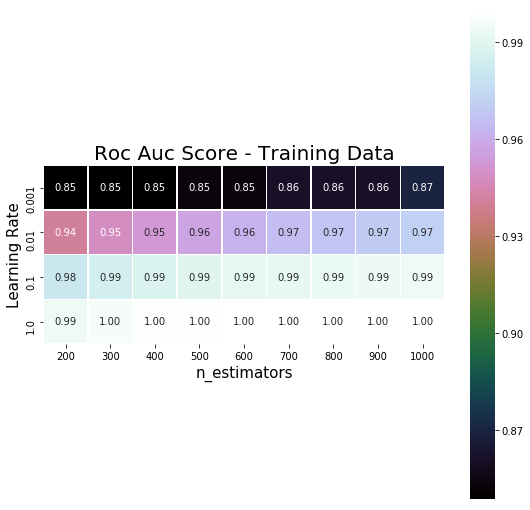

In [65]:
displayhmap = drawgraphs()

pivot_tbl = xgbst_bow.xgbst_hmap_trainB.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

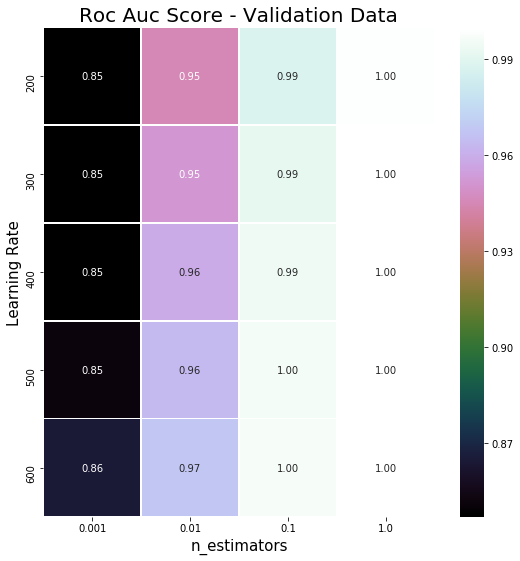

In [8]:
pivot_tbl = xgbst_bow.xgbst_hmap_valB.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [36]:
xgbst_bow.XGBST_actClasifier(900,10,0.1,True)

***X_test predict [1 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     14719
           1       0.90      0.97      0.94     14719

   micro avg       0.93      0.93      0.93     29438
   macro avg       0.94      0.93      0.93     29438
weighted avg       0.94      0.93      0.93     29438

*** predict probabilities*** [0.93366659 0.00386214 0.9167012  ... 0.00358285 0.00358273 0.00393021]


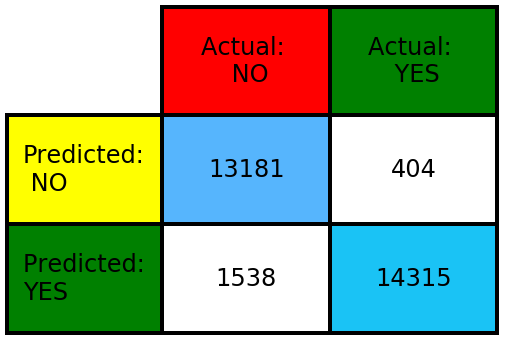

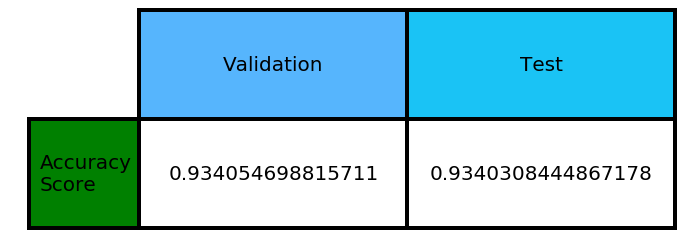

In [37]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_bow.confsnmtxytstpred['tn'] ,xgbst_bow.confsnmtxytstpred['fn']],[xgbst_bow.confsnmtxytstpred['fp'],xgbst_bow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_bow.accuracy_score_val,xgbst_bow.accuracy_score_test]]
displaygraph.draw_accscore(data1)

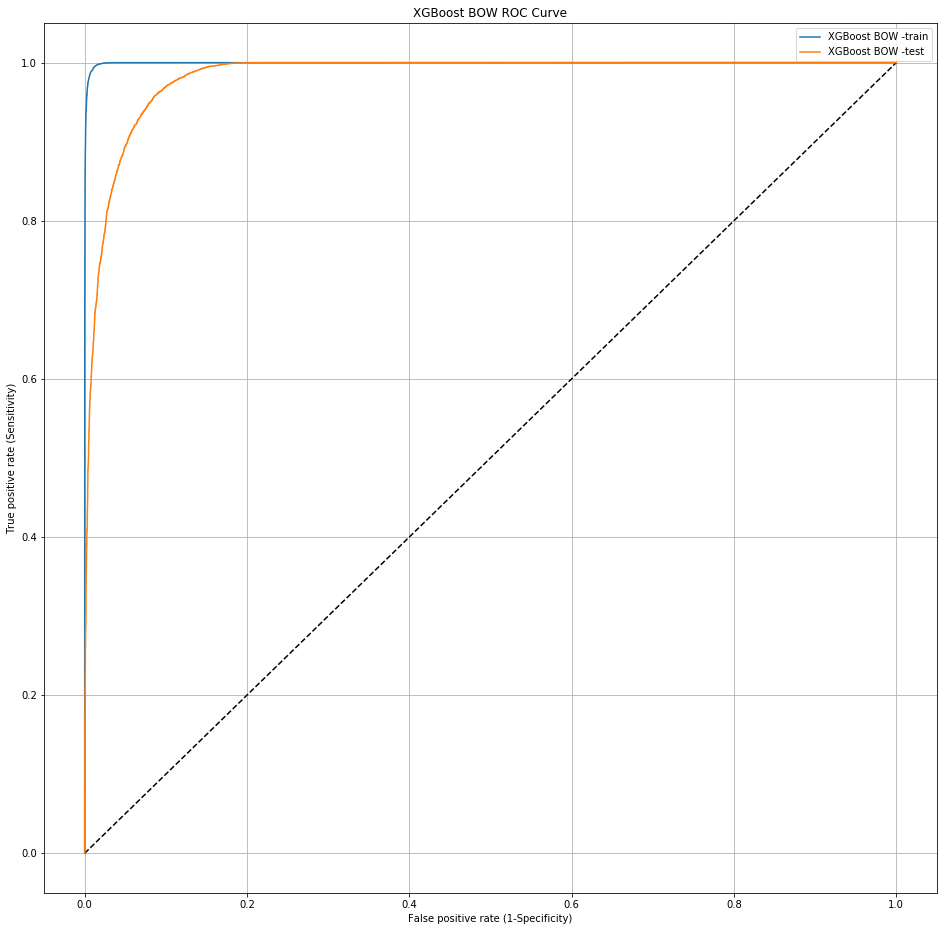

In [38]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost BOW ROC Curve'
displaygraph.legnd_1 = 'XGBoost BOW -train'
displaygraph.legnd_2 = 'XGBoost BOW -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_bow.roc_curve_test['fpr_trn'],xgbst_bow.roc_curve_test['tpr_trn'],\
                            xgbst_bow.roc_curve_test['fpr'],xgbst_bow.roc_curve_test['tpr'])

#### Data set has not been balanced ####

In [39]:
xgbst_bow = assign9XGBoost()
xgbst_bow.load_data('BOW')
print(xgbst_bow.xtrain.shape)
print(xgbst_bow.xval.shape)
xgbst_bow_clf = xgbst_bow.XgBstClasifierNoWts()

X_train shape (70218, 1000)
y_train shape (70218,)
X_test shape (17555, 1000)
y_test shape (17555,)
(56174, 1000)
(14044, 1000)


In [9]:
xgbst_bow_clf = xgbst_bow.XgBstClasifierNoWts()
#xgbst_bow.XGBST_calcrocaucscore()

Function exiting...


In [40]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/BOW_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_bow.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/BOW_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_bow.xgbst_hmap_val = pickle.load(fp)

In [41]:
print(xgbst_bow.xgbst_hmap_train.shape,xgbst_bow.xgbst_hmap_val.shape)

(72, 3) (72, 3)


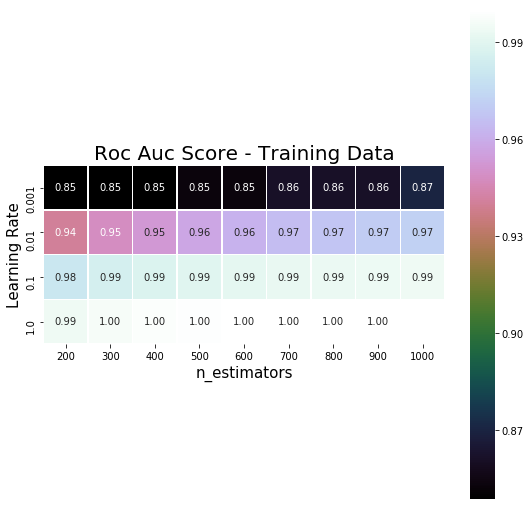

In [66]:
displayhmap = drawgraphs()
xgbst_bow.xgbst_hmap_train = xgbst_bow.xgbst_hmap_train[0:35]
pivot_tbl = xgbst_bow.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

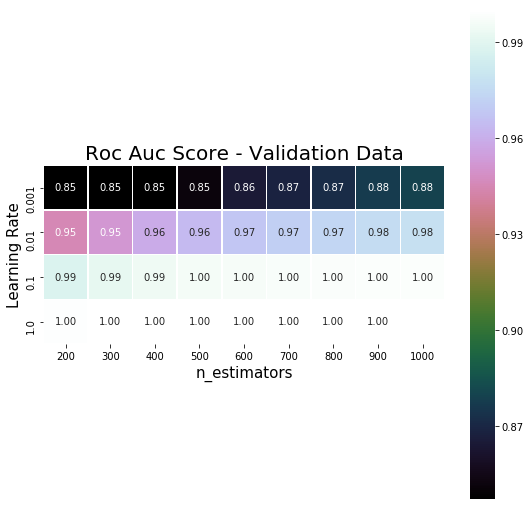

In [67]:
xgbst_bow.xgbst_hmap_val = xgbst_bow.xgbst_hmap_val[0:35]
pivot_tbl = xgbst_bow.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [44]:
xgbst_bow.XGBST_actClasifier(1000,9,0.1,False)

***X_test predict [1 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.80      0.60      0.68      2836
           1       0.93      0.97      0.95     14719

   micro avg       0.91      0.91      0.91     17555
   macro avg       0.86      0.78      0.82     17555
weighted avg       0.91      0.91      0.91     17555

*** predict probabilities*** [0.96052414 0.03349579 0.86684066 ... 0.91363317 0.9606722  0.96045882]


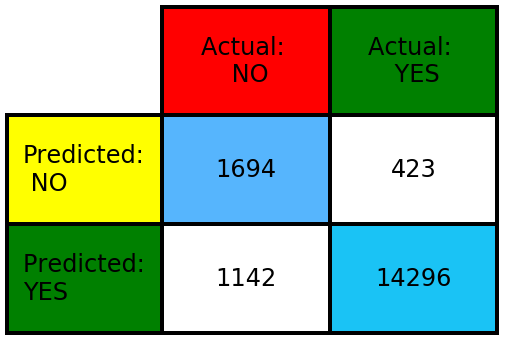

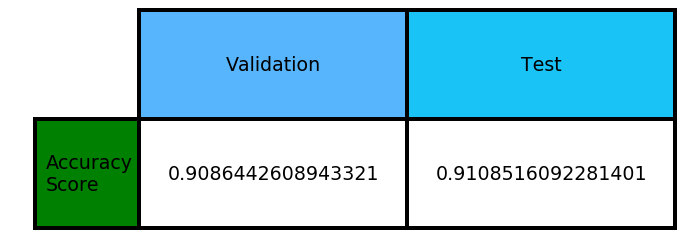

In [45]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_bow.confsnmtxytstpred['tn'] ,xgbst_bow.confsnmtxytstpred['fn']],[xgbst_bow.confsnmtxytstpred['fp'],xgbst_bow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_bow.accuracy_score_val,xgbst_bow.accuracy_score_test]]
displaygraph.draw_accscore(data1)

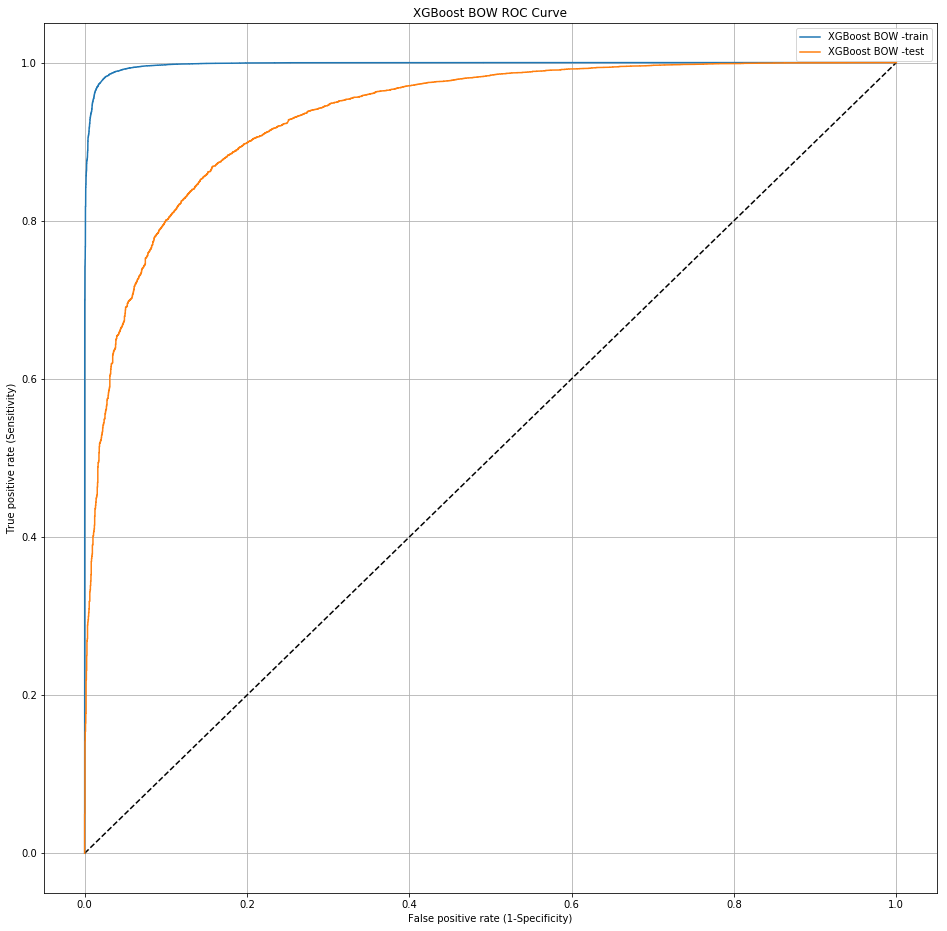

In [46]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost BOW ROC Curve'
displaygraph.legnd_1 = 'XGBoost BOW -train'
displaygraph.legnd_2 = 'XGBoost BOW -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_bow.roc_curve_test['fpr_trn'],xgbst_bow.roc_curve_test['tpr_trn'],\
                            xgbst_bow.roc_curve_test['fpr'],xgbst_bow.roc_curve_test['tpr'])

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

#### Data has been balanced ####

In [47]:
xgbst_tfidf = assign9XGBoost()
xgbst_tfidf.load_data('TFIDFBAL')
print(xgbst_tfidf.xtrain.shape)
print(xgbst_tfidf.xval.shape)
xgbst_tfidf_clf = xgbst_tfidf.XgBstClasifier()

X_train shape (117746, 500)
y_train shape (117746,)
X_test shape (29438, 500)
y_test shape (29438,)
(94272, 500)
(23474, 500)


In [15]:
xgbst_tfidf_clf = xgbst_tfidf.XgBstClasifier()
xgbst_tfidf.XGBST_calcrocaucscore()

Function exiting...


In [70]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/TFIDFBAL_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_tfidf.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/TFIDFBAL_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_tfidf.xgbst_hmap_val = pickle.load(fp)


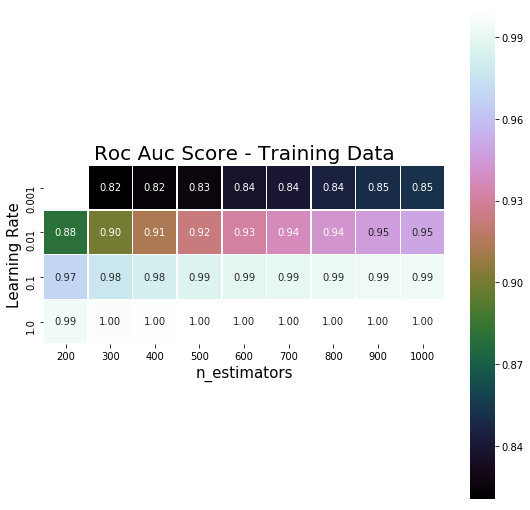

In [72]:
displayhmap = drawgraphs()
xgbst_tfidf.xgbst_hmap_train = xgbst_tfidf.xgbst_hmap_train[73:108]
pivot_tbl = xgbst_tfidf.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

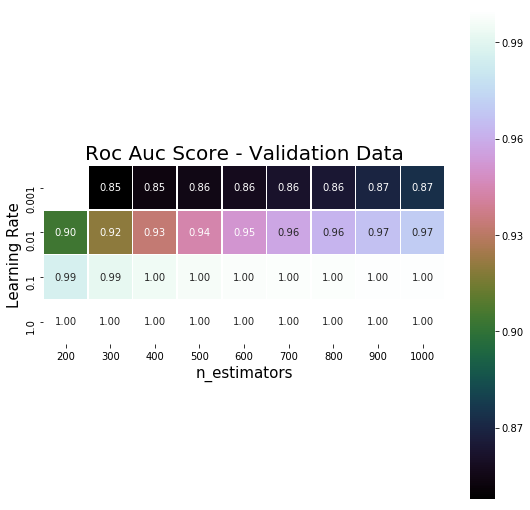

In [73]:
xgbst_tfidf.xgbst_hmap_val = xgbst_tfidf.xgbst_hmap_val[73:108]
pivot_tbl = xgbst_tfidf.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [74]:
xgbst_tfidf.XGBST_actClasifier(1000,10,0.1,True)

***X_test predict [1 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.94      0.84      0.88     14719
           1       0.85      0.94      0.90     14719

   micro avg       0.89      0.89      0.89     29438
   macro avg       0.90      0.89      0.89     29438
weighted avg       0.90      0.89      0.89     29438

*** predict probabilities*** [0.89079881 0.00441198 0.86349833 ... 0.1838163  0.00446226 0.00575043]


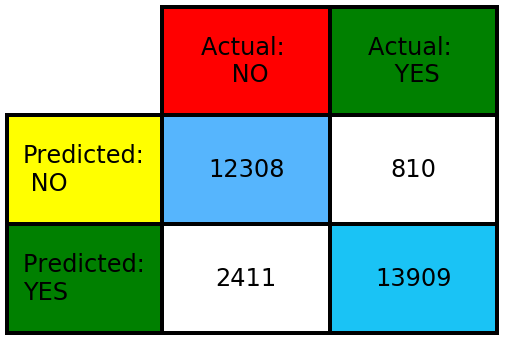

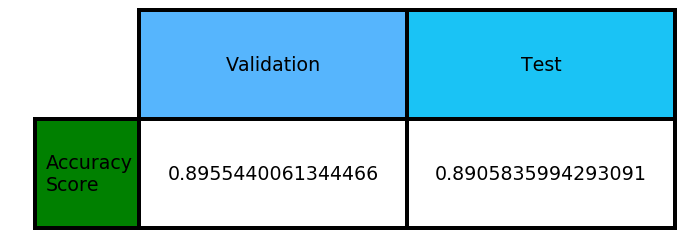

In [75]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_tfidf.confsnmtxytstpred['tn'] ,xgbst_tfidf.confsnmtxytstpred['fn']],[xgbst_tfidf.confsnmtxytstpred['fp'],xgbst_tfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_tfidf.accuracy_score_val,xgbst_tfidf.accuracy_score_test]]
displaygraph.draw_accscore(data1)

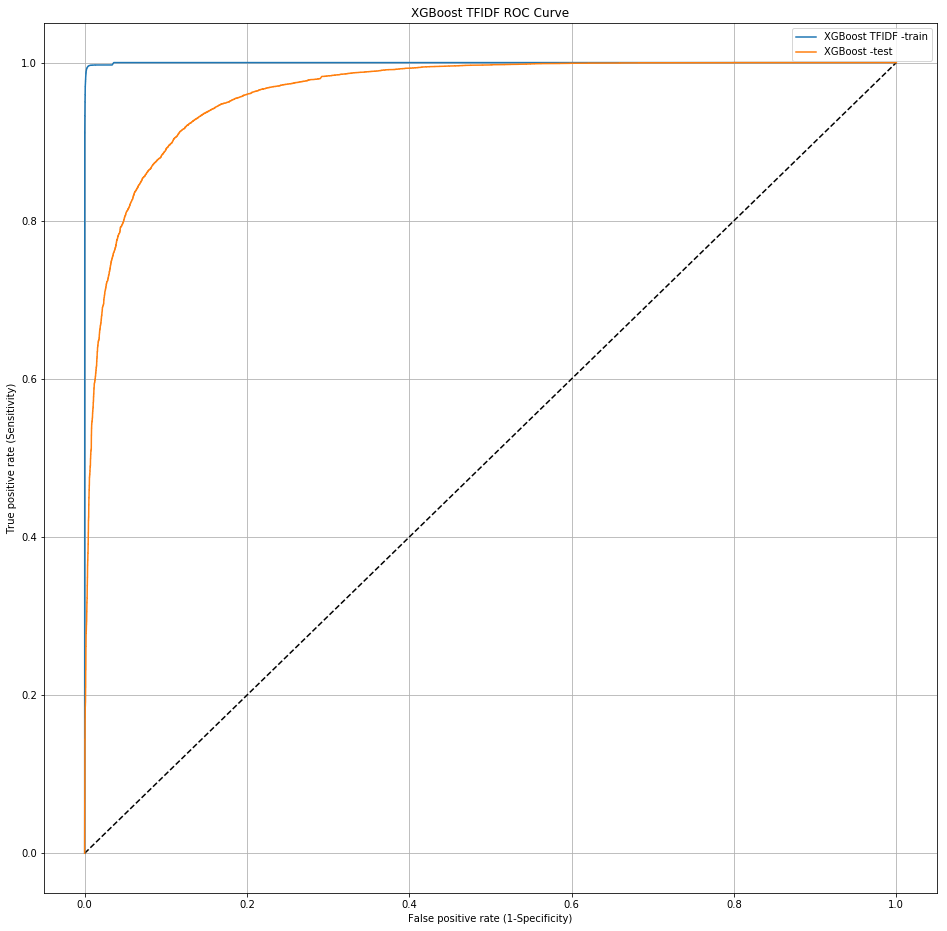

In [76]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost TFIDF ROC Curve'
displaygraph.legnd_1 = 'XGBoost TFIDF -train'
displaygraph.legnd_2 = 'XGBoost -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_tfidf.roc_curve_test['fpr_trn'],xgbst_tfidf.roc_curve_test['tpr_trn'],\
                            xgbst_tfidf.roc_curve_test['fpr'],xgbst_tfidf.roc_curve_test['tpr'])

#### Data has not been balanced ####

In [77]:
xgbst_tfidf = assign9XGBoost()
xgbst_tfidf.load_data('TFIDF')
print(xgbst_tfidf.xtrain.shape)
print(xgbst_tfidf.xval.shape)
xgbst_tfidf_clf = xgbst_tfidf.XgBstClasifierNoWts()

X_train shape (70218, 500)
y_train shape (70218,)
X_test shape (17555, 500)
y_test shape (17555,)
(56174, 500)
(14044, 500)


In [ ]:
xgbst_tfidf_clf = xgbst_tfidf.XgBstClasifierNoWts()
xgbst_tfidf.XGBST_calcrocaucscore()

In [78]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/TFIDF_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_tfidf.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/TFIDF_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_tfidf.xgbst_hmap_val = pickle.load(fp)


In [80]:
print(xgbst_tfidf.xgbst_hmap_train.shape,xgbst_tfidf.xgbst_hmap_val.shape)


(144, 3) (144, 3)


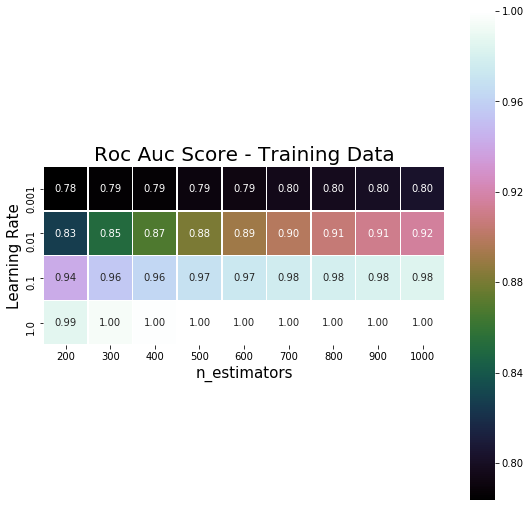

In [81]:
displayhmap = drawgraphs()
xgbst_tfidf.xgbst_hmap_train = xgbst_tfidf.xgbst_hmap_train[108:144]
pivot_tbl = xgbst_tfidf.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

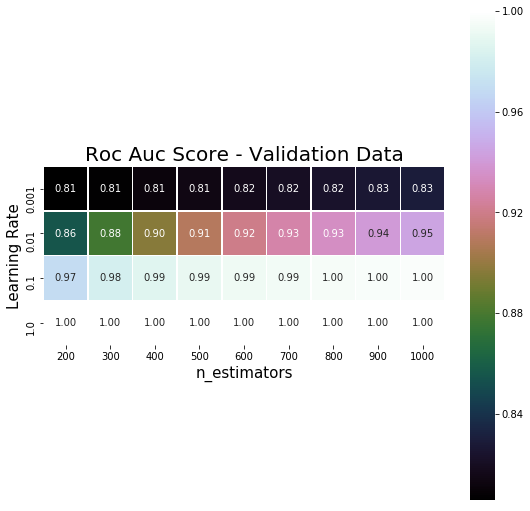

In [82]:
xgbst_tfidf.xgbst_hmap_val = xgbst_tfidf.xgbst_hmap_val[108:144]
pivot_tbl = xgbst_tfidf.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [83]:
xgbst_tfidf.XGBST_actClasifier(1000,5,0.1,False)

***X_test predict [1 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.75      0.52      0.61      2836
           1       0.91      0.97      0.94     14719

   micro avg       0.89      0.89      0.89     17555
   macro avg       0.83      0.74      0.78     17555
weighted avg       0.89      0.89      0.89     17555

*** predict probabilities*** [0.95544279 0.03319743 0.93258989 ... 0.90138251 0.96176481 0.96134073]


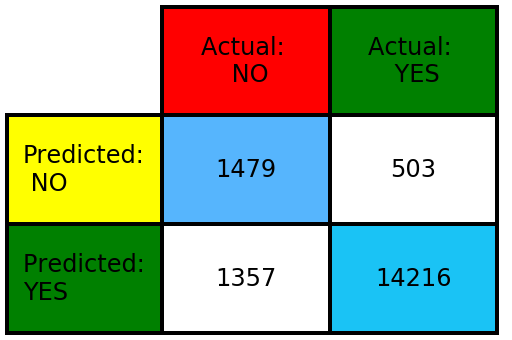

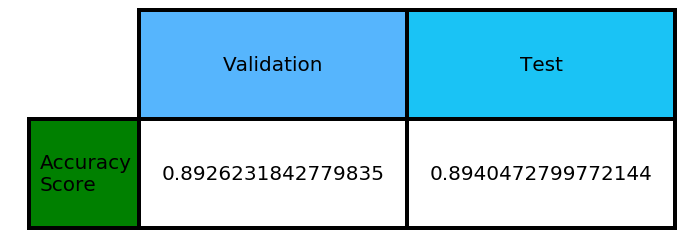

In [84]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_tfidf.confsnmtxytstpred['tn'] ,xgbst_tfidf.confsnmtxytstpred['fn']],[xgbst_tfidf.confsnmtxytstpred['fp'],xgbst_tfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_tfidf.accuracy_score_val,xgbst_tfidf.accuracy_score_test]]
displaygraph.draw_accscore(data1)

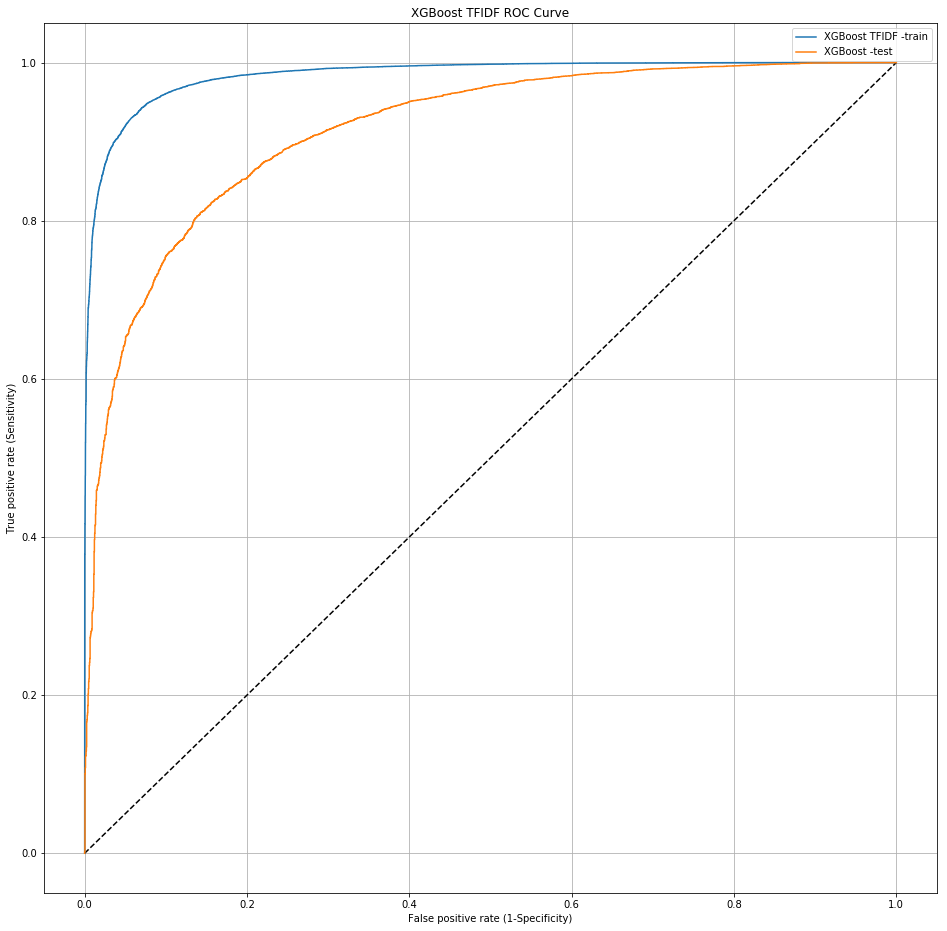

In [85]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost TFIDF ROC Curve'
displaygraph.legnd_1 = 'XGBoost TFIDF -train'
displaygraph.legnd_2 = 'XGBoost -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_tfidf.roc_curve_test['fpr_trn'],xgbst_tfidf.roc_curve_test['tpr_trn'],\
                            xgbst_tfidf.roc_curve_test['fpr'],xgbst_tfidf.roc_curve_test['tpr'])

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

#### Dataset has been balanced ####

In [86]:
xgbst_avgw2v = assign9XGBoost()
xgbst_avgw2v.load_data('AVGW2VBAL')
xgbst_avgw2v.vectrizer= 'AVGW2VBAL'
print(xgbst_avgw2v.xtrain.shape)
print(xgbst_avgw2v.xval.shape)
xgbst_avgw2v_clf = xgbst_avgw2v.XgBstClasifier()

X_train shape (12762, 50)
y_train shape (12762,)
X_test shape (3190, 50)
y_test shape (3190,)
(10250, 50)
(2512, 50)


In [ ]:
xgbst_avgw2v_clf = xgbst_avgw2v.XgBstClasifier()
xgbst_avgw2v.XGBST_calcrocaucscore()

In [93]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/AVGW2VBAL_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_avgw2v.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/AVGW2VBAL_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_avgw2v.xgbst_hmap_val = pickle.load(fp)


In [94]:
print(xgbst_avgw2v.xgbst_hmap_train.shape,xgbst_avgw2v.xgbst_hmap_val.shape)

(180, 3) (180, 3)


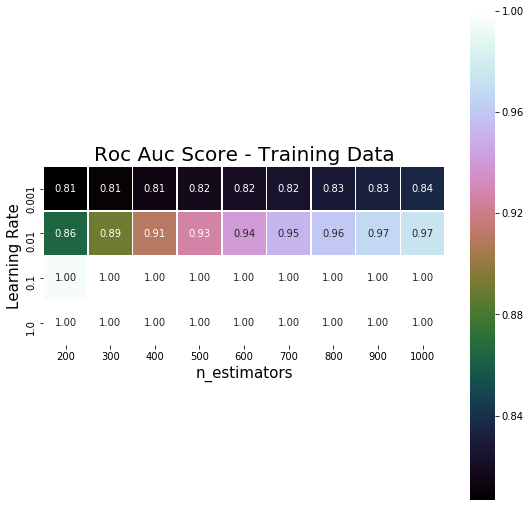

In [95]:
displayhmap = drawgraphs()
xgbst_avgw2v.xgbst_hmap_train = xgbst_avgw2v.xgbst_hmap_train[144:180]
pivot_tbl = xgbst_avgw2v.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

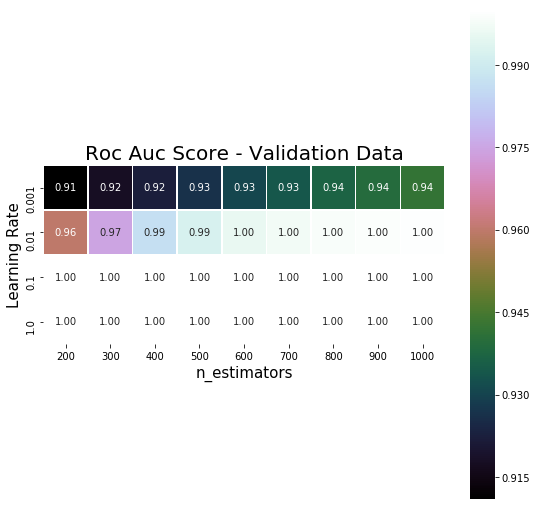

In [96]:
xgbst_avgw2v.xgbst_hmap_val = xgbst_avgw2v.xgbst_hmap_val[144:180]
pivot_tbl = xgbst_avgw2v.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [97]:
xgbst_avgw2v.XGBST_actClasifier(1000,10,0.1,True)

***X_test predict [1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.57      0.14      0.23      1595
           1       0.51      0.89      0.65      1595

   micro avg       0.52      0.52      0.52      3190
   macro avg       0.54      0.52      0.44      3190
weighted avg       0.54      0.52      0.44      3190

*** predict probabilities*** [0.51086253 0.51037067 0.51121336 ... 0.5086776  0.50902456 0.50399774]


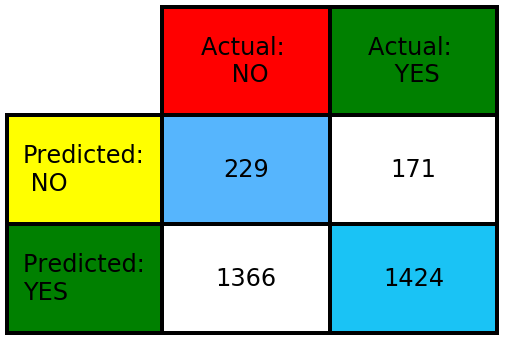

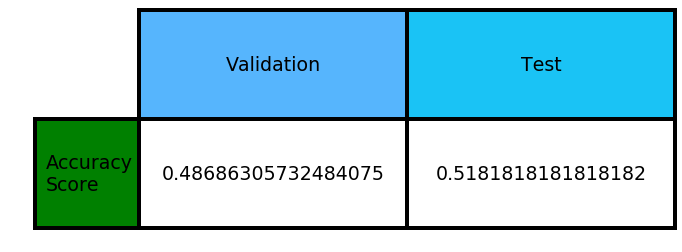

In [98]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_avgw2v.confsnmtxytstpred['tn'] ,xgbst_avgw2v.confsnmtxytstpred['fn']],[xgbst_avgw2v.confsnmtxytstpred['fp'],xgbst_avgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_avgw2v.accuracy_score_val,xgbst_avgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

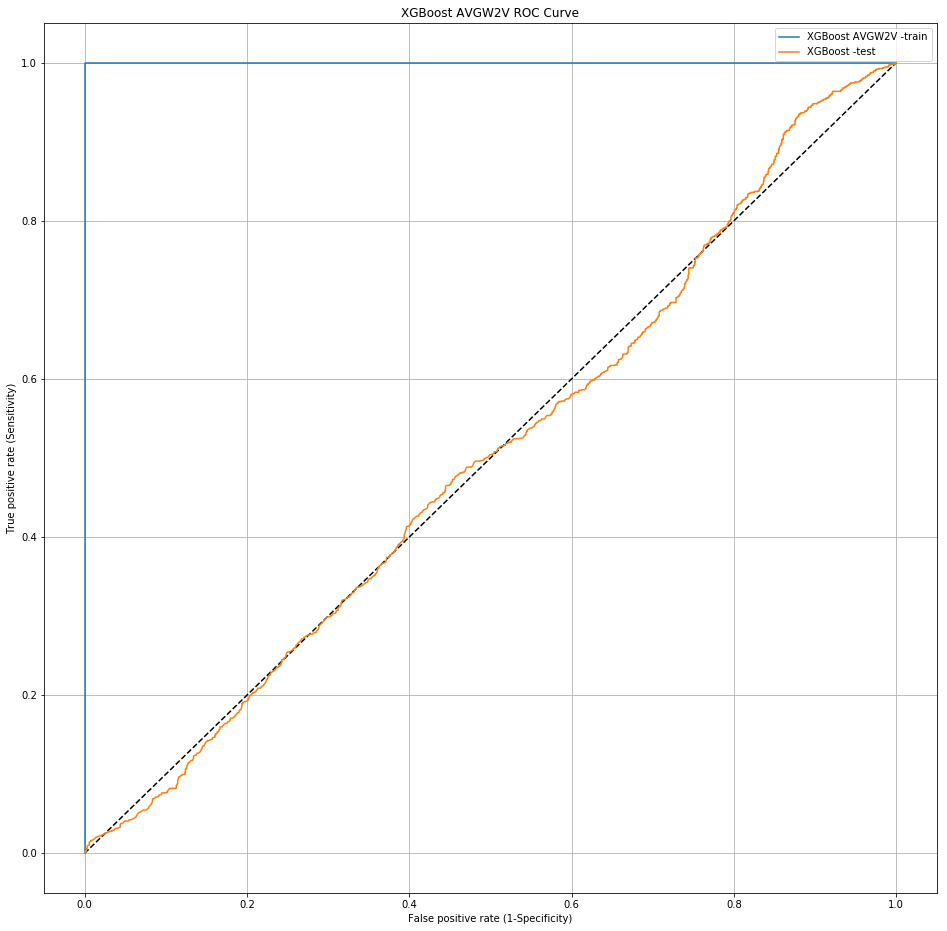

In [99]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost AVGW2V ROC Curve'
displaygraph.legnd_1 = 'XGBoost AVGW2V -train'
displaygraph.legnd_2 = 'XGBoost -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_avgw2v.roc_curve_test['fpr_trn'],xgbst_avgw2v.roc_curve_test['tpr_trn'],\
                            xgbst_avgw2v.roc_curve_test['fpr'],xgbst_avgw2v.roc_curve_test['tpr'])

#### Data  set has not been balanced ####

In [100]:
xgbst_avgw2v = assign9XGBoost()
xgbst_avgw2v.load_data('AVGW2V')
xgbst_avgw2v.vectrizer= 'AVGW2V'
print(xgbst_avgw2v.xtrain.shape)
print(xgbst_avgw2v.xval.shape)
xgbst_avgw2v_clf = xgbst_avgw2v.XgBstClasifier()

X_train shape (7651, 50)
y_train shape (7651,)
X_test shape (1913, 50)
y_test shape (1913,)
(6120, 50)
(1531, 50)


In [23]:
xgbst_avgw2v_clf = xgbst_avgw2v.XgBstClasifier()
xgbst_avgw2v.XGBST_calcrocaucscore()

Function exiting...


In [101]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/AVGW2V_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
     xgbst_avgw2v.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/AVGW2V_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:
    xgbst_avgw2v.xgbst_hmap_val = pickle.load(fp)


In [102]:
print(xgbst_avgw2v.xgbst_hmap_train.shape,xgbst_avgw2v.xgbst_hmap_val.shape)

(216, 3) (216, 3)


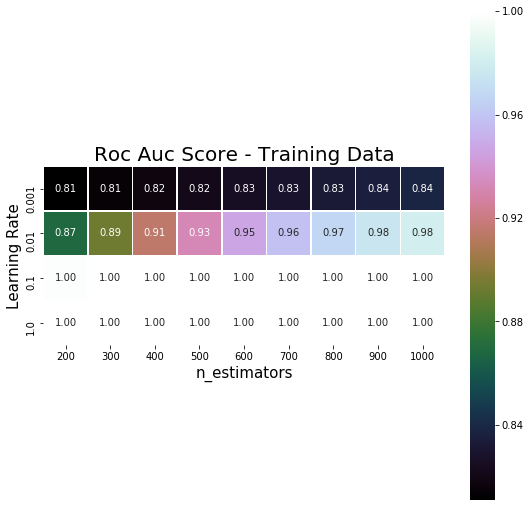

In [103]:
displayhmap = drawgraphs()
xgbst_avgw2v.xgbst_hmap_train = xgbst_avgw2v.xgbst_hmap_train[180:216]
pivot_tbl = xgbst_avgw2v.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

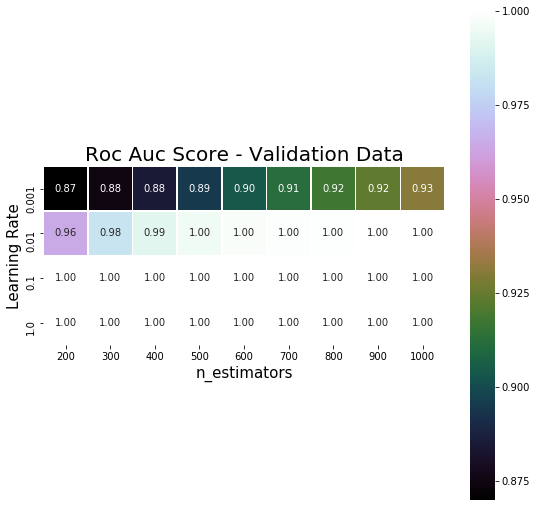

In [104]:
xgbst_avgw2v.xgbst_hmap_val = xgbst_avgw2v.xgbst_hmap_val[180:216]
pivot_tbl = xgbst_avgw2v.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [105]:
xgbst_avgw2v.XGBST_actClasifier(1000,5,0.01,False)

***X_test predict [1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.83      1.00      0.91      1595

   micro avg       0.83      0.83      0.83      1913
   macro avg       0.42      0.50      0.45      1913
weighted avg       0.70      0.83      0.76      1913

*** predict probabilities*** [0.81372517 0.8137821  0.82606673 ... 0.82021099 0.85202777 0.82298708]


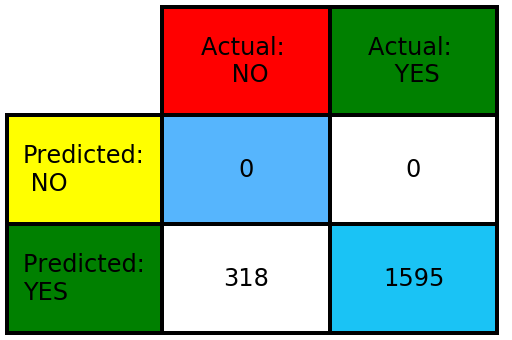

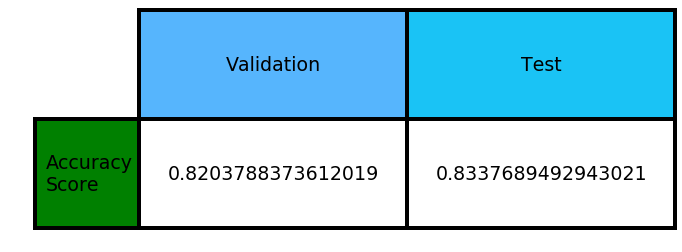

In [106]:

displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_avgw2v.confsnmtxytstpred['tn'] ,xgbst_avgw2v.confsnmtxytstpred['fn']],[xgbst_avgw2v.confsnmtxytstpred['fp'],xgbst_avgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_avgw2v.accuracy_score_val,xgbst_avgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

In [ ]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost AVGW2V ROC Curve'
displaygraph.legnd_1 = 'XGBoost AVGW2V -train'
displaygraph.legnd_2 = 'XGBoost -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_avgw2v.roc_curve_test['fpr_trn'],xgbst_avgw2v.roc_curve_test['tpr_trn'],\
                            xgbst_avgw2v.roc_curve_test['fpr'],xgbst_avgw2v.roc_curve_test['tpr'])

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

#### Dataset has been balanced ####

In [116]:
xgbst_wtw2v = assign9XGBoost()
xgbst_wtw2v.load_data('WTW2VBAL')
xgbst_wtw2v.vectrizer= 'WTW2VBAL'
print(xgbst_wtw2v.xtrain.shape)
print(xgbst_wtw2v.xval.shape)
xgbst_wtw2v_clf = xgbst_wtw2v.XgBstClasifier()

X_train shape (12762, 50)
y_train shape (12762,)
X_test shape (3190, 50)
y_test shape (3190,)
(10250, 50)
(2512, 50)


In [ ]:
xgbst_wtw2v_clf = xgbst_wtw2v.XgBstClasifier()
xgbst_wtw2v.XGBST_calcrocaucscore()

In [117]:
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/WTW2VBAL_xgbst_hmap_train.out'
with open (fname, 'rb') as fp:
    xgbst_wtw2v.xgbst_hmap_train = pickle.load(fp)
fname = 'E:/appliedaicourse/assignments/assign-9-rndforest/WTW2VBAL_xgbst_hmap_cval.out'        
with open (fname, 'rb') as fp:    
    xgbst_wtw2v.xgbst_hmap_val = pickle.load(fp)

In [118]:
print(xgbst_wtw2v.xgbst_hmap_train.shape,xgbst_wtw2v.xgbst_hmap_val.shape)

(36, 3) (36, 3)


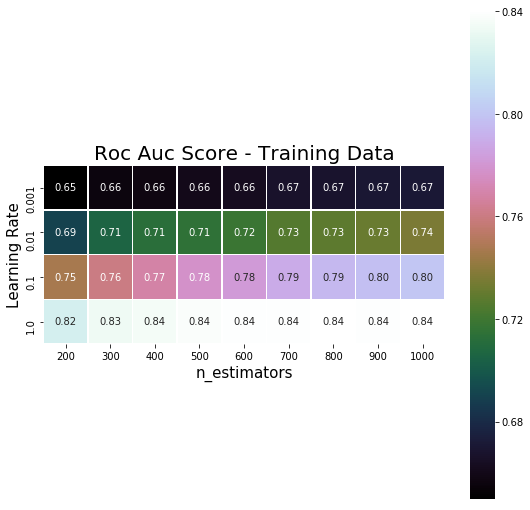

In [119]:
displayhmap = drawgraphs()

pivot_tbl = xgbst_wtw2v.xgbst_hmap_train.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Training Data','n_estimators','Learning Rate')

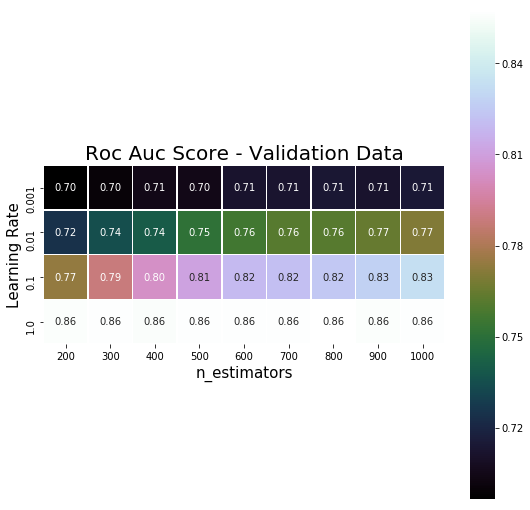

In [120]:
pivot_tbl = xgbst_wtw2v.xgbst_hmap_val.pivot(index='learnrate',columns='nestimators',values='rocaucscore').head()
displayhmap.draw_heatmap(pivot_tbl,'Roc Auc Score - Validation Data','n_estimators','Learning Rate')

In [121]:
xgbst_wtw2v.XGBST_actClasifier(500,10,1,True)

***X_test predict [1 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.50      0.21      0.30      1595
           1       0.50      0.79      0.61      1595

   micro avg       0.50      0.50      0.50      3190
   macro avg       0.50      0.50      0.45      3190
weighted avg       0.50      0.50      0.45      3190

*** predict probabilities*** [0.50217056 0.48830903 0.49008268 ... 0.50217056 0.50217056 0.50217056]


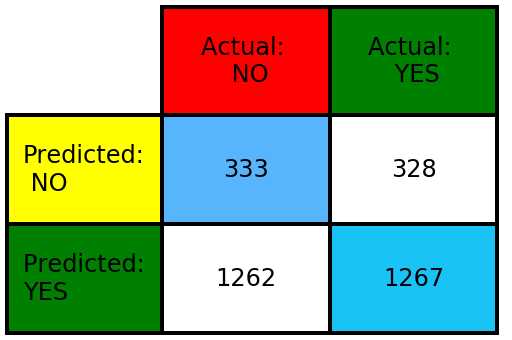

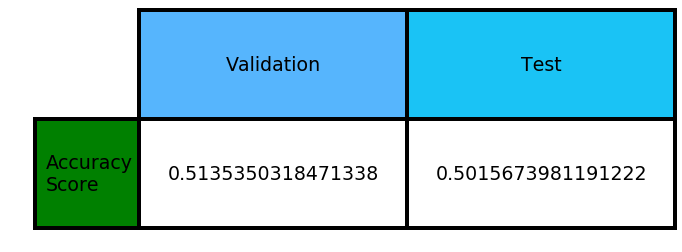

In [122]:
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
data = [[xgbst_wtw2v.confsnmtxytstpred['tn'] ,xgbst_wtw2v.confsnmtxytstpred['fn']],[xgbst_wtw2v.confsnmtxytstpred['fp'],xgbst_wtw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[xgbst_wtw2v.accuracy_score_val,xgbst_wtw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

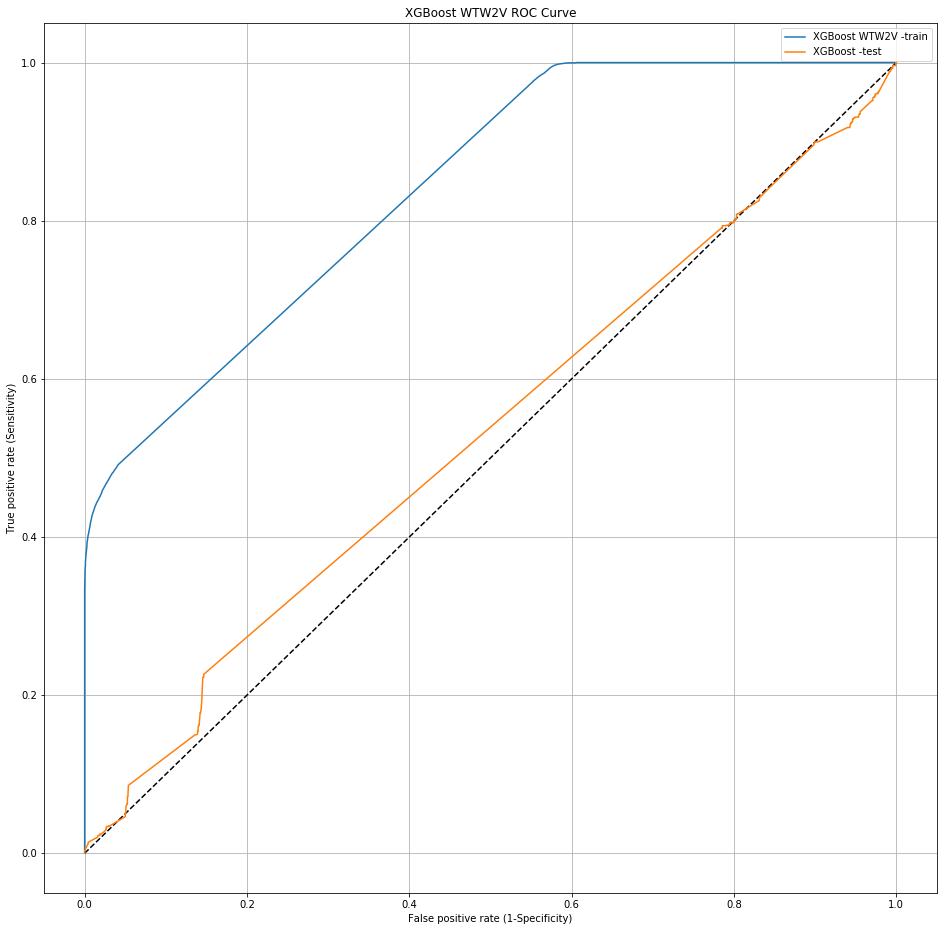

In [123]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='XGBoost WTW2V ROC Curve'
displaygraph.legnd_1 = 'XGBoost WTW2V -train'
displaygraph.legnd_2 = 'XGBoost -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(xgbst_wtw2v.roc_curve_test['fpr_trn'],xgbst_wtw2v.roc_curve_test['tpr_trn'],\
                            xgbst_wtw2v.roc_curve_test['fpr'],xgbst_wtw2v.roc_curve_test['tpr'])

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

### Summary of Results - Random forest ###

In [1]:
import tabulate

In [5]:
final_concln_param_rf = [['Parameters','BOW \nBalanced','BOW','TfIdf \nBalanced','TfIdf','AVGW2V \nBalanced','AVGW2V','WTW2V \nBalanced','WTW2V'],
                   ['Max_Depth',20,20,20,20,20,15,14,15],
                   ['Min_samples \nLeaf',50,50,50,50,50,50,50,50],
                   ['n_estimators',300,800,800,700,1000,900,700,500]
                    ]
print(tabulate.tabulate(final_concln_param_rf,tablefmt='fancy_grid'))

╒══════════════╤══════════╤═════╤══════════╤═══════╤══════════╤════════╤══════════╤═══════╕
│ Parameters   │ BOW      │ BOW │ TfIdf    │ TfIdf │ AVGW2V   │ AVGW2V │ WTW2V    │ WTW2V │
│              │ Balanced │     │ Balanced │       │ Balanced │        │ Balanced │       │
├──────────────┼──────────┼─────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ Max_Depth    │ 20       │ 20  │ 20       │ 20    │ 20       │ 15     │ 14       │ 15    │
├──────────────┼──────────┼─────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ Min_samples  │ 50       │ 50  │ 50       │ 50    │ 50       │ 50     │ 50       │ 50    │
│ Leaf         │          │     │          │       │          │        │          │       │
├──────────────┼──────────┼─────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ n_estimators │ 300      │ 800 │ 800      │ 700   │ 1000     │ 900    │ 700      │ 500   │
╘══════════════╧══════════╧═════╧══════════╧═══════╧══════════╧════════╧════════

In [6]:
final_concln_metrix_rf = [['Evaluation \nMetric','BOW \nBalanced','BOW','TfIdf \nBalanced','TfIdf','AVGW2V \nBalanced','AVGW2V','WTW2V \nBalanced','WTW2V'],
                   ['Accuracy',0.802,0.805,0.773,0.8055,0.714,0.739,0.55,0.35]
                    ]
print(tabulate.tabulate(final_concln_metrix_rf,tablefmt='fancy_grid'))

╒═════════════╤══════════╤═══════╤══════════╤════════╤══════════╤════════╤══════════╤═══════╕
│ Evaluation  │ BOW      │ BOW   │ TfIdf    │ TfIdf  │ AVGW2V   │ AVGW2V │ WTW2V    │ WTW2V │
│ Metric      │ Balanced │       │ Balanced │        │ Balanced │        │ Balanced │       │
├─────────────┼──────────┼───────┼──────────┼────────┼──────────┼────────┼──────────┼───────┤
│ Accuracy    │ 0.802    │ 0.805 │ 0.773    │ 0.8055 │ 0.714    │ 0.739  │ 0.55     │ 0.35  │
╘═════════════╧══════════╧═══════╧══════════╧════════╧══════════╧════════╧══════════╧═══════╛


### Summary of Results - XGBoost ###

In [7]:
final_concln_param_xgb = [['Parameters','BOW \nBalanced','BOW','TfIdf \nBalanced','TfIdf','AVGW2V \nBalanced','AVGW2V','WTW2V \nBalanced','WTW2V'],
                   ['Max_Depth',10,9,10,5,10,5,10,10],
                   ['Learning \nRate',0.1,0.1,0.1,0.1,0.1,0.01,1,0.01],
                   ['n_estimators',900,1000,1000,1000,1000,1000,500,50]
                    ]
print(tabulate.tabulate(final_concln_param_xgb,tablefmt='fancy_grid'))

╒══════════════╤══════════╤══════╤══════════╤═══════╤══════════╤════════╤══════════╤═══════╕
│ Parameters   │ BOW      │ BOW  │ TfIdf    │ TfIdf │ AVGW2V   │ AVGW2V │ WTW2V    │ WTW2V │
│              │ Balanced │      │ Balanced │       │ Balanced │        │ Balanced │       │
├──────────────┼──────────┼──────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ Max_Depth    │ 10       │ 9    │ 10       │ 5     │ 10       │ 5      │ 10       │ 10    │
├──────────────┼──────────┼──────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ Learning     │ 0.1      │ 0.1  │ 0.1      │ 0.1   │ 0.1      │ 0.01   │ 1        │ 0.01  │
│ Rate         │          │      │          │       │          │        │          │       │
├──────────────┼──────────┼──────┼──────────┼───────┼──────────┼────────┼──────────┼───────┤
│ n_estimators │ 900      │ 1000 │ 1000     │ 1000  │ 1000     │ 1000   │ 500      │ 50    │
╘══════════════╧══════════╧══════╧══════════╧═══════╧══════════╧══════

In [11]:
final_concln_metrix_xgb = [['Evaluation \nMetric','BOW \nBalanced','BOW','TfIdf \nBalanced','TfIdf','AVGW2V \nBalanced','AVGW2V','WTW2V \nBalanced','WTW2V \n*'],
                   ['Accuracy',0.934,0.9109,0.8906,0.8940,0.5181,0.8338,0.5015,0.0]
                    ]
print(tabulate.tabulate(final_concln_metrix_xgb,tablefmt='fancy_grid'))
print('* With an un-balanced dataset vectorized using Tfidf weighted Word2Vector, processing it using an XGBoost classifier \
        is overfitting hence that models results have been excluded ')

╒═════════════╤══════════╤════════╤══════════╤═══════╤══════════╤════════╤══════════╤════════╕
│ Evaluation  │ BOW      │ BOW    │ TfIdf    │ TfIdf │ AVGW2V   │ AVGW2V │ WTW2V    │ WTW2V  │
│ Metric      │ Balanced │        │ Balanced │       │ Balanced │        │ Balanced │ *      │
├─────────────┼──────────┼────────┼──────────┼───────┼──────────┼────────┼──────────┼────────┤
│ Accuracy    │ 0.934    │ 0.9109 │ 0.8906   │ 0.894 │ 0.5181   │ 0.8338 │ 0.5015   │ 0.0    │
╘═════════════╧══════════╧════════╧══════════╧═══════╧══════════╧════════╧══════════╧════════╛
* With an un-balanced dataset vectorized using Tfidf weighted Word2Vector, processing it using an XGBoost classifier         is overfitting hence that models results have been excluded 
